In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-store-games/steam_support_info.csv
/kaggle/input/steam-store-games/steam_media_data.csv
/kaggle/input/steam-store-games/steamspy_tag_data.csv
/kaggle/input/steam-store-games/steam_requirements_data.csv
/kaggle/input/steam-store-games/steam_description_data.csv
/kaggle/input/steam-store-games/steam.csv


ben bu alıştırmamda bir oyun şirketinin işini yapıyorum. bana ellerindeki steam datalarını verdiler ve yeni çıkaracakları oyun için bir araştırma yapmamı istediler.steam oyunlarının keşifsel analizine başlamadan önce kullancağım kütüphaneleri ve veri dosylayarını yükledim. 

In [2]:
import pandas as pd
df_steam = pd.read_csv('/kaggle/input/steam-store-games/steam.csv')
#dosyaları yükleyip yüklemediğime bakmak için ilk satırları gösterdim
print(df_steam.head())
#çalışmamda kullanacağım görselleştirme ve veri analizi kütüphanelerini yükledim
import pandas as pd
import numpy as np
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


   appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat

Birden Fazla Dosyanın Yüklenmesi ve Eksik Veri Analizi
- Steam mağazasıyla ilgili farklı verileri içeren CSV dosyaları yüklendi:
  - `steam.csv`: Temel oyun bilgileri.
  - `steam_description_data.csv`: Oyun açıklamaları.
  - `steam_media_data.csv`: Oyunlarla ilgili medya dosyaları.
  - `steam_requirements_data.csv`: Sistem gereksinimleri.
  - `steam_support_info.csv`: Teknik destek bilgileri.
  - `steamspy_tag_data.csv`: Oyun etiketleri ve kategorileri.
Kodda Yapılan İşlemler:
Dosyaların Yüklenmesi:
Tüm CSV dosyaları tek bir Python sözlüğünde (`dataframes`) yüklendi. Her bir dosya adı, bu sözlükte bir anahtar olarak kullanıldı.
Neden Bu Adımlar Yapıldı?
Proje dosyasında eksik veri yoksa yaratmamız isteniyordu.


In [3]:
# burada yardım almak zorunda kaldım çünkü ilk yazdığım kodla yalnızca steam.csv dosyasına bakabilmiştim. daha sonra bu dosyaları birleştirmek ve bakmanın nasıl olacağını düşündüm.

import pandas as pd
base_path = '/kaggle/input/steam-store-games/'
file_names = {'steam': 'steam.csv',
    'description': 'steam_description_data.csv',
    'media': 'steam_media_data.csv',
    'requirements': 'steam_requirements_data.csv',
    'support': 'steam_support_info.csv',
    'tags': 'steamspy_tag_data.csv'}

# Dosyaları tek bir yere yükle
dataframes = {name: pd.read_csv(base_path + file) for name, file in file_names.items()}

#infoyu ve eksik dataları kontrol et
for name, df in dataframes.items():
    print(f"--- {name.upper()} DATAFRAME ---")
    print("Genel Bilgi:")
    df.info()
    print("\nEksik Veri Sayısı:")
    print(df.isnull().sum())
    print("\nEksik Veri Yüzdesi:")
    print((df.isnull().sum() / len(df)) * 100)
    print("\n")



--- STEAM DATAFRAME ---
Genel Bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  own

eksik verileri doldurdum.
- `developer` ve `publisher` sütunlarında eksik veriler tespit ettim. Bu sütunlar sözel (kategorik) veriler içerdiği için, eksik verileri aşağıdaki yöntemle doldurdum:
Eksik değerler, mevcut sütundaki rastgele bir değerle (`np.random.choice`) dolduruldu
sonuçları:
- Eksik veri sayısının sıfıra düştüğünü göreceğiz.
- `developer` ve `publisher` sütunlarındaki tüm eksiklikler giderildi.


In [4]:
#publisher ve developer kısımlarında eksiklikleri fark ettim ve bunlar sözel/kategorize bilgiler olduğu için unknown ve missing olarak doldurmayi düşündüm ama projede doldurulması gerektiği yazdığı için mevcut değerlerin içindekilerle random doldurmayı düşündüm.

for column in ['developer', 'publisher']:
 df_steam[column] = df_steam[column].apply(lambda x: np.random.choice(df_steam[column].dropna()) if pd.isnull(x) else x)

#eksik veriler dolduruldu mu kontrolü için
print("Eksik Veri Sayısı:\n") 
print(df_steam.isnull().sum())


Eksik Veri Sayısı:

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64



- Eksik veriler başarıyla doldurulduktan sonr veri setini kaydettim.
- Bu işlem, temizlenen veri setinin ileride tekrar kullanılabilmesi ve analizlerin daha düzenli bir şekilde yapılabilmesi için önemlidir.
- Çalışma kaydedildiyse bir belirttiğim yazının yazmasını istedim.


In [5]:
#eksik verilerimin doldurulduğunu gördükten sonra çalışmayı kaydetmek istiyorum. eğer çalışma kaydedildiyse beam me up, scotty yazmasını istiyorum.

df_steam.to_csv('steam_cleaned.csv', index=False)
print("beam me up, Scotty!")



beam me up, Scotty!


Geliştirici ve Yayıncıların Oyun Sayıları
En Çok Oyuna Sahip Geliştiriciler: Steam'de en fazla oyuna sahip ilk 10 geliştirici listelendi.
En Çok Oyuna Sahip Yayıncılar En fazla oyunu yayınlayan ilk 10 yayıncı listelendi.
Geliştiricilerin ve Yayıncıların Tür Dağılımı
Geliştiricilerin Tür Dağılımı: İlk 10 geliştiricinin geliştirdiği oyun türleri analiz edildi.
Yayıncıların Tür Dağılımı: İlk 10 yayıncının yayınladığı oyun türleri analiz edildi.
Türler, geliştiriciler ve yayıncıların odaklandıkları alanları anlamak için gruplandırıldı.
Yayıncıların Tür Dağılımını Gösteren Pie Chart
Yayıncıların yayınladığı oyun türlerinin yüzdelik dağılımı bir pasta grafiğiyle görselleştirildi.
Amaç: Yayıncıların hangi türlerde daha aktif olduğunu göstermek.
Pasta grafikte her bir türün toplam yayınlar içindeki oranı görselleştirildi.



En Çok Oyuna Sahip Geliştiriciler:

developer
Choice of Games               94
KOEI TECMO GAMES CO., LTD.    72
Ripknot Systems               62
Laush Dmitriy Sergeevich      51
Nikita "Ghost_RUS"            50
Dexion Games                  45
RewindApp                     43
Hosted Games                  42
Blender Games                 40
For Kids                      36
Name: count, dtype: int64
\En Çok Oyuna Sahip Yayıncılar:

publisher
Big Fish Games         212
Strategy First         136
Ubisoft                111
THQ Nordic              98
Square Enix             97
Sekai Project           96
Choice of Games         94
1C Entertainment        88
Dagestan Technology     88
SEGA                    78
Name: count, dtype: int64


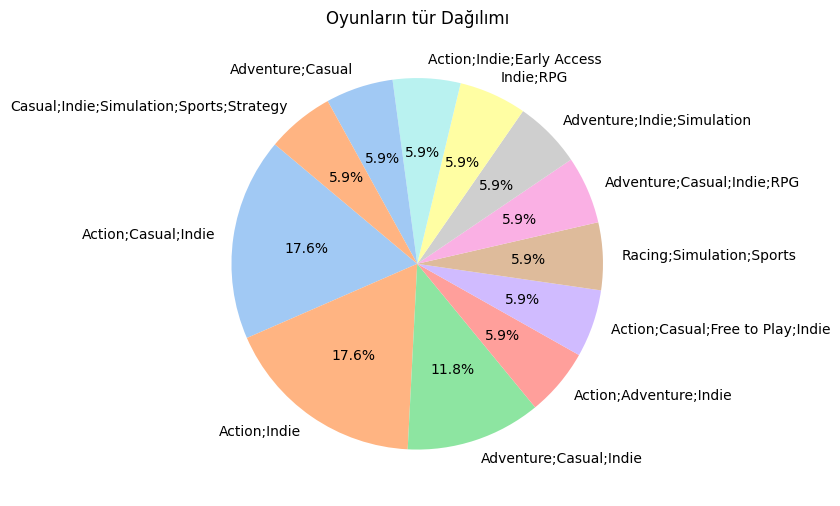

In [6]:
# developerların oyun sayıları
top_developers = df_steam['developer'].value_counts().head(10)
# publisherların oyun sayıları
top_publishers = df_steam['publisher'].value_counts().head(10)
# Sonuçlar 
print("En Çok Oyuna Sahip Geliştiriciler:\n")
print(top_developers)
print("\En Çok Oyuna Sahip Yayıncılar:\n")
print(top_publishers)

import matplotlib.pyplot as plt
from collections import Counter
# developerların tür dağılımı
developer_genre_counts = Counter(', '.join(df_steam.groupby('developer')['genres'].apply(lambda x: ', '.join(x)).head(10)).split(', '))
developer_genre_df = pd.DataFrame(developer_genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
# publisherların genre dağılımı
publisher_genre_counts = Counter(', '.join(df_steam.groupby('publisher')['genres'].apply(lambda x: ', '.join(x)).head(10)).split(', '))
publisher_genre_df = pd.DataFrame(publisher_genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
#oyun genrelarının toplam içindeki yüzdelik dilimin gösteren pie chart grafiği
plt.figure(figsize=(8, 8))
plt.pie(
    publisher_genre_df['Count'], 
    labels=publisher_genre_df['Genre'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'))
plt.title("Oyunların tür Dağılımı", fontsize=12)
plt.tight_layout()
plt.show()



Pozitif ve Negatif Değerlendirme Alan Oyunların Analizi
**Amaç:** Steam üzerindeki oyunlar arasında en çok pozitif ve en çok negatif değerlendirme alan ilk 10 oyunu belirlemek.
**Yapılan İşlemler:**
**Pozitif Değerlendirme:** `positive_ratings` sütununa göre sıralama yapılarak en çok pozitif oy alan 10 oyun listelendi.
**Negatif Değerlendirme:** `negative_ratings` sütununa göre sıralama yapılarak en çok negatif oy alan 10 oyun listelendi.
- **En Çok Pozitif Oy Alan Oyunlar:** Kullanıcılar tarafından en beğenilen oyunlar.
- **En Çok Negatif Oy Alan Oyunlar:** Kullanıcı memnuniyetsizliğinin yüksek olduğu oyunlar.


In [7]:
# Pozitif oy alan 10 oyun
top_positive_ratings = df_steam.sort_values(by="positive_ratings", ascending=False).head(10)
print("En Çok Pozitif Değerlendirme Alan Oyunlar:")
print(top_positive_ratings[['name', 'positive_ratings']])
# Negatif oy alan 10 oyun
top_negative_ratings = df_steam.sort_values(by="negative_ratings", ascending=False).head(10)
print("\nEn Çok Negatif Değerlendirme Alan Oyunlar:")
print(top_negative_ratings[['name', 'negative_ratings']])




En Çok Pozitif Değerlendirme Alan Oyunlar:
                                   name  positive_ratings
25     Counter-Strike: Global Offensive           2644404
22                               Dota 2            863507
19                      Team Fortress 2            515879
12836     PLAYERUNKNOWN'S BATTLEGROUNDS            496184
121                         Garry's Mod            363721
2478                 Grand Theft Auto V            329061
1467                           PAYDAY 2            308657
3362                           Unturned            292574
1120                           Terraria            255600
21                        Left 4 Dead 2            251789

En Çok Negatif Değerlendirme Alan Oyunlar:
                                   name  negative_ratings
12836     PLAYERUNKNOWN'S BATTLEGROUNDS            487076
25     Counter-Strike: Global Offensive            402313
22                               Dota 2            142079
2478                 Grand Theft Auto V    

Türlere Göre Pozitif ve Negatif Oyların Dağılımı
**Amaç:** Oyun türleri bazında pozitif ve negatif oy dağılımlarını analiz etmek ve görselleştirmek.
- Grafik, oyun türleri için pozitif ve negatif oyların toplamını yan yana görselleştirir.
- Kullanıcıların en çok beğendiği ve memnuniyetsiz olduğu türler aynı grafikte gösterilerek kıyaslama yapılabilir.
yorum:
**Aksiyon türü**, pozitif oylarla öne çıkarken, aynı zamanda yüksek negatif oy oranına da sahip olabilir.
Daha özeltürler, genellikle daha düşük negatif oy oranlarıyla daha az risk taşır.


Türlere Göre Değerlendirme:
                              positive_ratings  negative_ratings
genres                                                          
Action;Free to Play                    3757019            547167
Action                                 3044378            539243
Action;Adventure                       2017871            501439
Action;RPG                             1031195            162693
RPG                                     938839            141339
Action;Free to Play;Strategy            871504            144158
Action;Indie                            768329            121597
Indie;Simulation                        733870             51216
Adventure;Indie                         666847             97448
Action;Adventure;Indie                  656555            103566


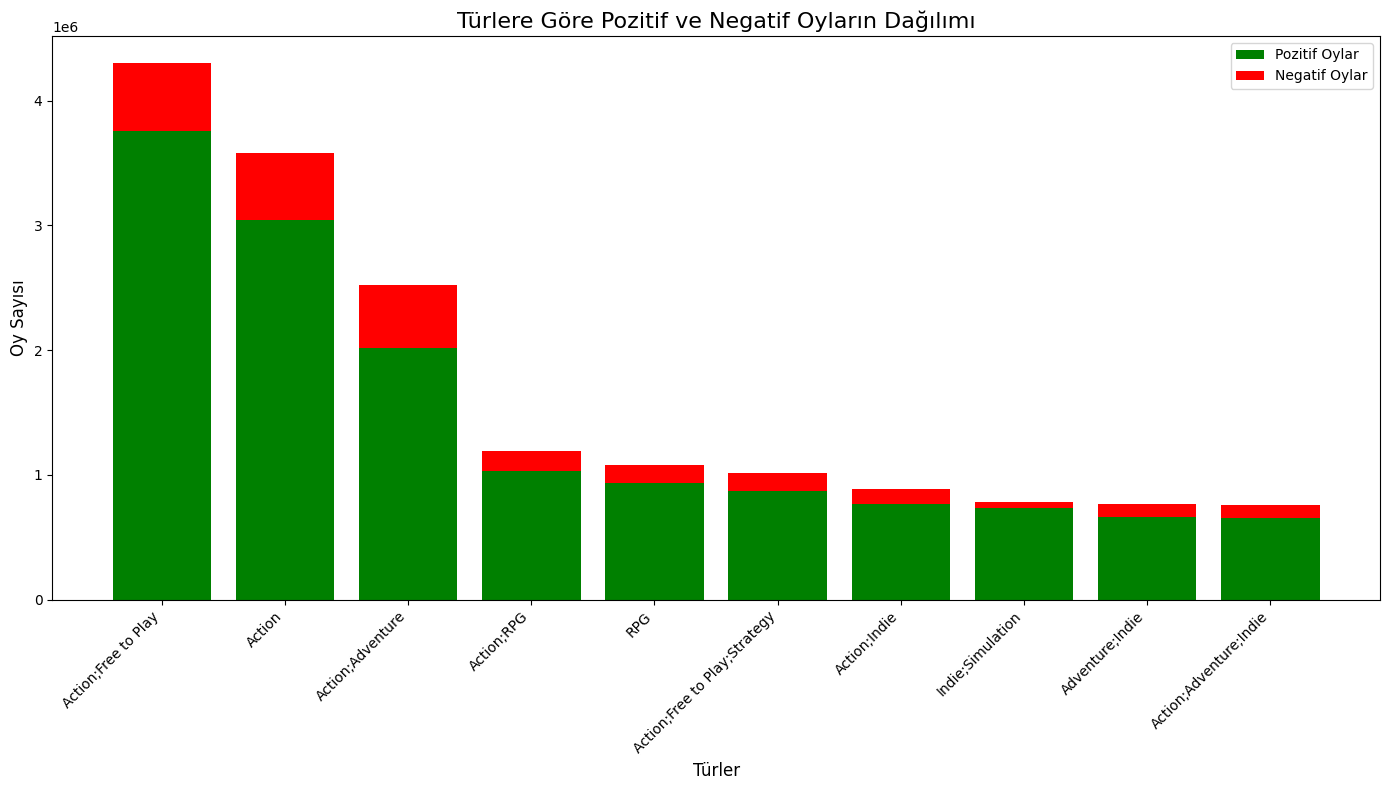

In [8]:
# yukarıda pozitif ve negatif oy alan oyunların türlerine göre dağılımlarına bakmak istedim
# pozitif ve negatif değerlendirmeler (genre)
genre_ratings = df_steam.groupby('genres')[['positive_ratings', 'negative_ratings']].sum()
# Pozitif ve negatif sıralama
genre_ratings = genre_ratings.sort_values(by="positive_ratings", ascending=False)
print("Türlere Göre Değerlendirme:")
print(genre_ratings.head(10))
import matplotlib.pyplot as plt
# İlk 10 tür
top_genres = genre_ratings.head(10)
# Çubuk grafiği ile verileri görselleştirme (negatif ve pozitif oylar aynı sütunda olacak şekilde)
plt.figure(figsize=(14, 8))
plt.bar(top_genres.index, top_genres['positive_ratings'], color='green', label='Pozitif Oylar')
plt.bar(top_genres.index, top_genres['negative_ratings'], bottom=top_genres['positive_ratings'], color='red', label='Negatif Oylar')
plt.title("Türlere Göre Pozitif ve Negatif Oyların Dağılımı", fontsize=16)
plt.xlabel("Türler", fontsize=12)
plt.ylabel("Oy Sayısı", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Pozitif ve Negatif Değerlendirme Alan Oyunların İsimleri
**Amaç:** En çok pozitif ve negatif oy alan ilk 10 oyunun isimlerini ve oy sayılarını listelemek.
içerik:
**En Çok Pozitif Oy Alan Oyunlar:** Kullanıcıların en beğendiği oyunların isimleri ve oy sayıları.
**En Çok Negatif Oy Alan Oyunlar:** Kullanıcı memnuniyetsizliğinin yüksek olduğu oyunların isimleri ve oy sayıları.
Daha sonra bu pozitif ve negatif oy alan ilk 10 oyunu görselleştirmek istedim. Başka grafik denemelerim kafa karıştırıcı olduğu için pozitif ve negatif oylamaları kendi içerisinde çubukk grafikleri ile gösterdim.


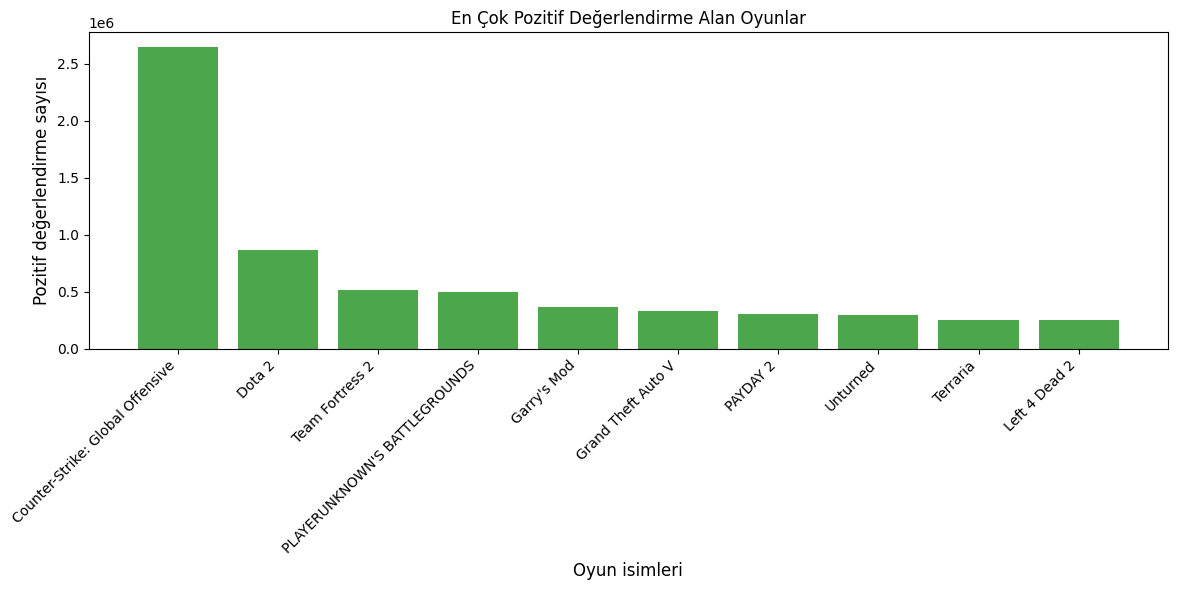

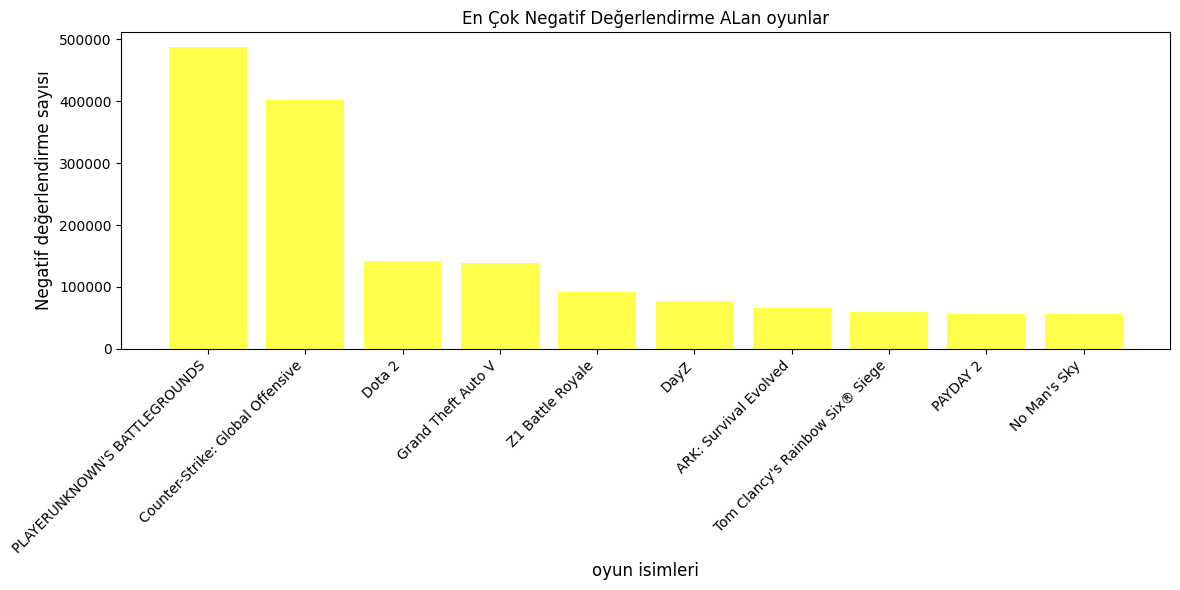

In [9]:
import matplotlib.pyplot as plt
# positive rating alan oyunlar
plt.figure(figsize=(12, 6))
plt.bar(top_positive_ratings['name'], top_positive_ratings['positive_ratings'], color='green', alpha=0.7)
plt.title("En Çok Pozitif Değerlendirme Alan Oyunlar", fontsize=12)
plt.xlabel("Oyun isimleri", fontsize=12)
plt.ylabel("Pozitif değerlendirme sayısı", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#negatif rating alan oyunlar
plt.figure(figsize=(12, 6))
plt.bar (top_negative_ratings['name'], top_negative_ratings['negative_ratings'], color= 'yellow', alpha=0.7)
plt.title("En Çok Negatif Değerlendirme ALan oyunlar", fontsize=12)
plt.xlabel("oyun isimleri", fontsize=12)
plt.ylabel("Negatif değerlendirme sayısı", fontsize= 12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Yıllara Göre Oyun Türlerinin Dağılımı
- **Amaç:** Oyun türlerinin yıllar içerisindeki popülerlik dağılımını analiz etmek.
Sonuçlar:
Grafik, belirli yıllarda hangi türlerin daha popüler olduğunu gösterir.
Trend analizi, türlerin zamanla artış veya azalış gösterip göstermediğini anlamamıza yardımcı olur.
**Aksiyon türleri**, yıllar boyunca sürekli popülerliğini koruyabilir.
Daha alışşılmadık türler belirli yıllarda kısa süreli yükselişler gösterebilir.


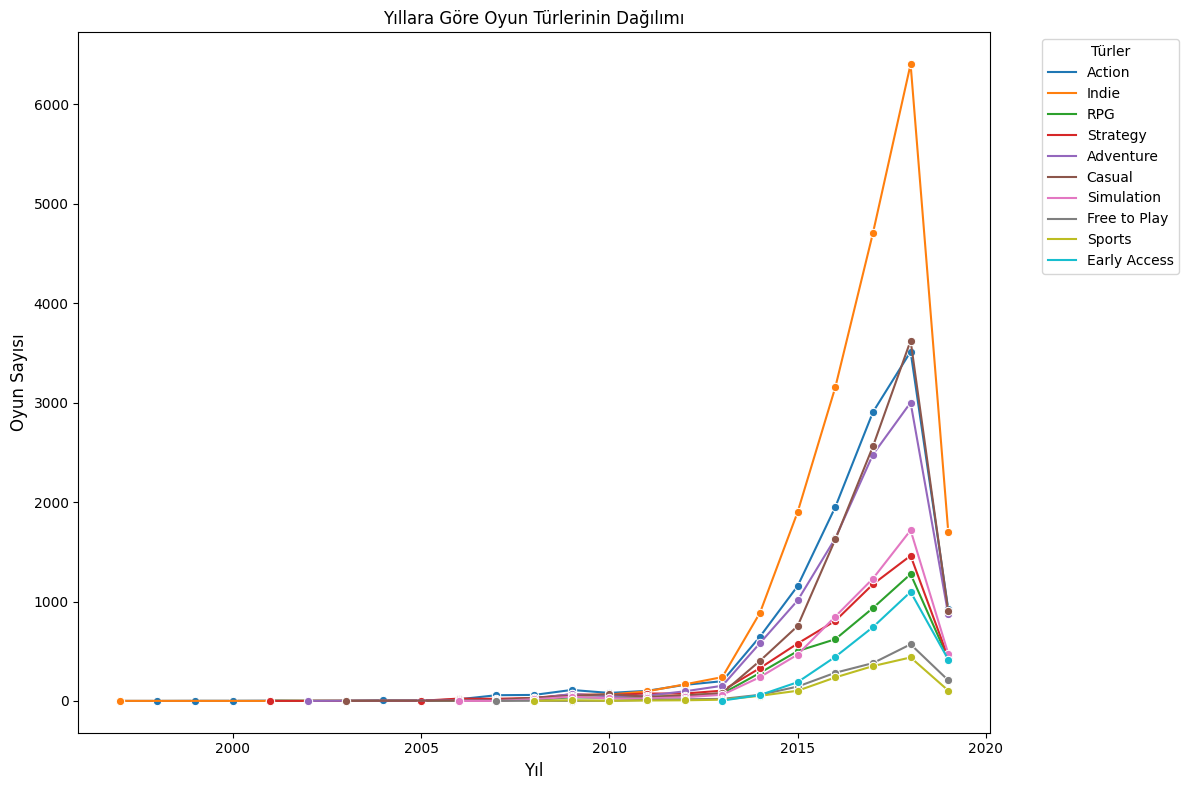

In [10]:
#steamdeki oyunları türlerine göre yukarıda ayırmıştım. yıllar içerisinde oyun türlerinde nasıl bir değişim var bakmak istedim.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#uyarıları bastır (sürekli uyarı aldım, yardım kullanarak bunun yardımı susturduğunu öğrendim)
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
import warnings
warnings.filterwarnings("ignore"),

#tarih sütununu datetime formatına çevir
df_steam['release_date'] = pd.to_datetime(df_steam['release_date'], errors='coerce')

#eksik tarih ve tür değerlerini düşür
df_steam = df_steam.dropna(subset=['release_date', 'genres'])

#yıl bilgisi sütunu oluştur
df_steam['release_year'] = df_steam['release_date'].dt.year

#türleri böl,yeni bir sütun oluştur
df_steam['genres_split'] = df_steam['genres'].str.split(';')

#verilerde inf değerlerini NaN olarak değiştir
df_steam = df_steam.replace([float('inf'), -float('inf')], pd.NA)

#türlere göre yıllık dağılım, sırala, yıla ve türe göre grupşa, sayıları tek bir grupta göster
genre_yearly_distribution = (
    df_steam.explode('genres_split')  
           .groupby(['release_year', 'genres_split'], dropna=True)  
           .size()
           .reset_index(name='count')  )

#en çok kullanılan ilk 10 türü seç 
top_genres = (
    df_steam.explode('genres_split')
            .groupby('genres_split')
            .size()
            .nlargest(10) 
            .index)
genre_yearly_distribution = genre_yearly_distribution[
    genre_yearly_distribution['genres_split'].isin(top_genres)]

#grafik
plt.figure(figsize=(12, 8))
palette = sns.color_palette("tab10", n_colors=len(top_genres))
sns.lineplot(
    data=genre_yearly_distribution,
    x='release_year',
    y='count',
    hue='genres_split',
    marker='o',
    palette=palette)
plt.title("Yıllara Göre Oyun Türlerinin Dağılımı", fontsize=12)
plt.xlabel("Yıl", fontsize=12)
plt.ylabel("Oyun Sayısı", fontsize=12)
plt.legend(title="Türler", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Oyun Fiyatı ile Pozitif ve Negatif Oylar Arasındaki Korelasyon
- **Amaç:** Oyun fiyatlarının pozitif ve negatif değerlendirme oranları üzerinde bir etkisi olup olmadığını incelemek.
Korelasyon Sonuçları:
Korelasyon katsayısı **0.00-0.39** ise zayıf bir ilişki, **0.40-0.69** ise orta düzey bir ilişki, **0.70+** ise güçlü bir ilişki olarak yorumlanabilir. Benim sonuçlarımda 0.04 ve 0.05 çıktı, zayıf bir ilişki olduğu görülebilir bu analizle.
Bu analizin oyunların fiyatlandırma stratejilerinin kullanıcı yorumları üzerindeki etkisini anlamada önemli bir role sahip olduğunu düşünerek yaptım


Pozitif Oylama ile Fiyat Arasındaki Korelasyon: 0.04
Negatif Oylama ile Fiyat Arasındaki Korelasyon: 0.05


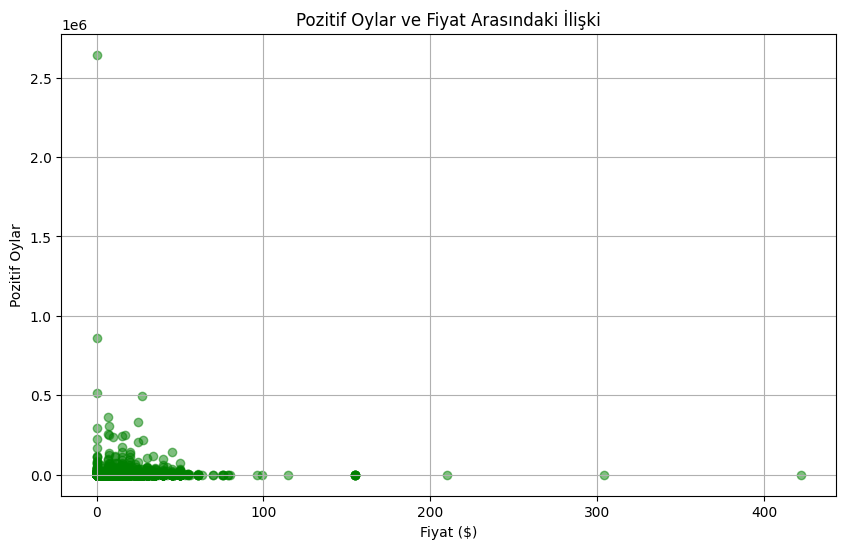

In [11]:
# Pozitif rating ve fiyat arasındaki korelasyon
positive_price_corr = df_steam[['positive_ratings', 'price']].corr().iloc[0, 1]
# Negatif rat,ng ve fiyat arasındaki korelasyon
negative_price_corr = df_steam[['negative_ratings', 'price']].corr().iloc[0, 1]

print(f"Pozitif Oylama ile Fiyat Arasındaki Korelasyon: {positive_price_corr:.2f}")
print(f"Negatif Oylama ile Fiyat Arasındaki Korelasyon: {negative_price_corr:.2f}")

# Scatter plot for positive ratings and price
plt.figure(figsize=(10, 6))
plt.scatter(df_steam['price'], df_steam['positive_ratings'], alpha=0.5, color='green')
plt.title("Pozitif Oylar ve Fiyat Arasındaki İlişki")
plt.xlabel("Fiyat ($)")
plt.ylabel("Pozitif Oylar")
plt.grid(True)
plt.show()



çıkan korelasyon sonucuna göre oyunların fiyatlarının pozitif ya da negatif oylamalara bir etkisi olmadığını görmüş oldum. o zaman bu oyları elimdeki verilerle, neye göre verdiklerini anlamaya çalışacağım.

Fiyat ile Ortalama Oynanma Süresi Arasındaki İlişki
- **Amaç:** Oyunların fiyatlarının ortalama oynanma süreleri üzerindeki etkisini analiz etmek.
- Korelasyon katsayısı, fiyat ile ortalama oynanma süresi arasındaki ilişkinin gücünü gösterir:
  -bende 0.05 çıktı yani zayıf bir ilişki olduğunu söyleyebilirim.


Fiyat ile Ortalama Oynanma Süresi Arasındaki Korelasyon: 0.05


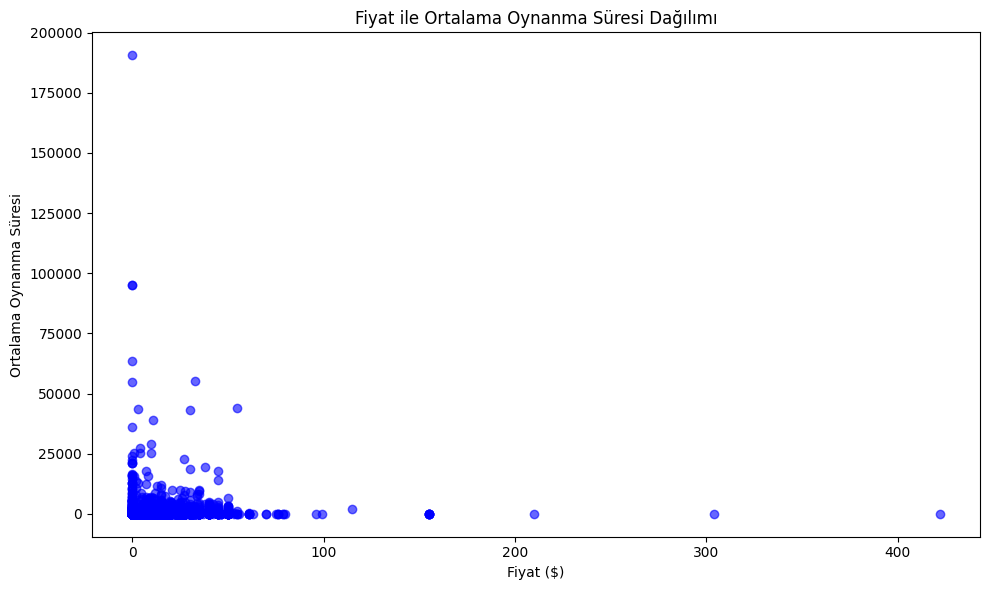

In [12]:
# Fiyat ve ortalama oynanma süresi korelasyonu
playtime_price_corr = df_steam[['price', 'average_playtime']].corr().iloc[0, 1]
print(f"Fiyat ile Ortalama Oynanma Süresi Arasındaki Korelasyon: {playtime_price_corr:.2f}")
# Grafik
plt.figure(figsize=(10, 6))
plt.scatter(df_steam['price'], df_steam['average_playtime'], alpha=0.6, color='blue')
plt.title("Fiyat ile Ortalama Oynanma Süresi Dağılımı")
plt.xlabel("Fiyat ($)")
plt.ylabel("Ortalama Oynanma Süresi")
plt.tight_layout()
plt.show()

En Çok Sahip Olunan Oyunların Oynanma Süreleri
Amaç:En çok sahip olunan oyunların ortalama ve medyan oynanma sürelerini analiz etmek.
-bu benim steam kütüphanemi düşünerek düşündüğüm bir şey, oynanmamış ama indirilmiş bir sürü oyunum olduğu için anlamlı bir sonuç alabileceğimi düşündüm.
Grafik, oyun sahiplikleri ile oynanma süreleri arasında bir paralellik olup olmadığını analiz etmek için ve oyuncu sadakatini anlayabilmek için yapmak istedim.



En Çok Sahip Olunan 10 Oyun ve Oynanma Süreleri:
                                   name              owners  average_playtime  \
25     Counter-Strike: Global Offensive  50000000-100000000             22494   
12836     PLAYERUNKNOWN'S BATTLEGROUNDS  50000000-100000000             22938   
258    Call of Duty®: Modern Warfare® 2    5000000-10000000               999   
2602             A Story About My Uncle    5000000-10000000               193   
903                       Borderlands 2    5000000-10000000              3276   
1596             Euro Truck Simulator 2    5000000-10000000              4942   
11791                       Black Squad    5000000-10000000              1835   
1547               No More Room in Hell    5000000-10000000              2661   
2964          The Witcher® 3: Wild Hunt    5000000-10000000              3068   
2502      Counter-Strike Nexon: Zombies    5000000-10000000              4047   

       median_playtime  
25                6502  
12836    

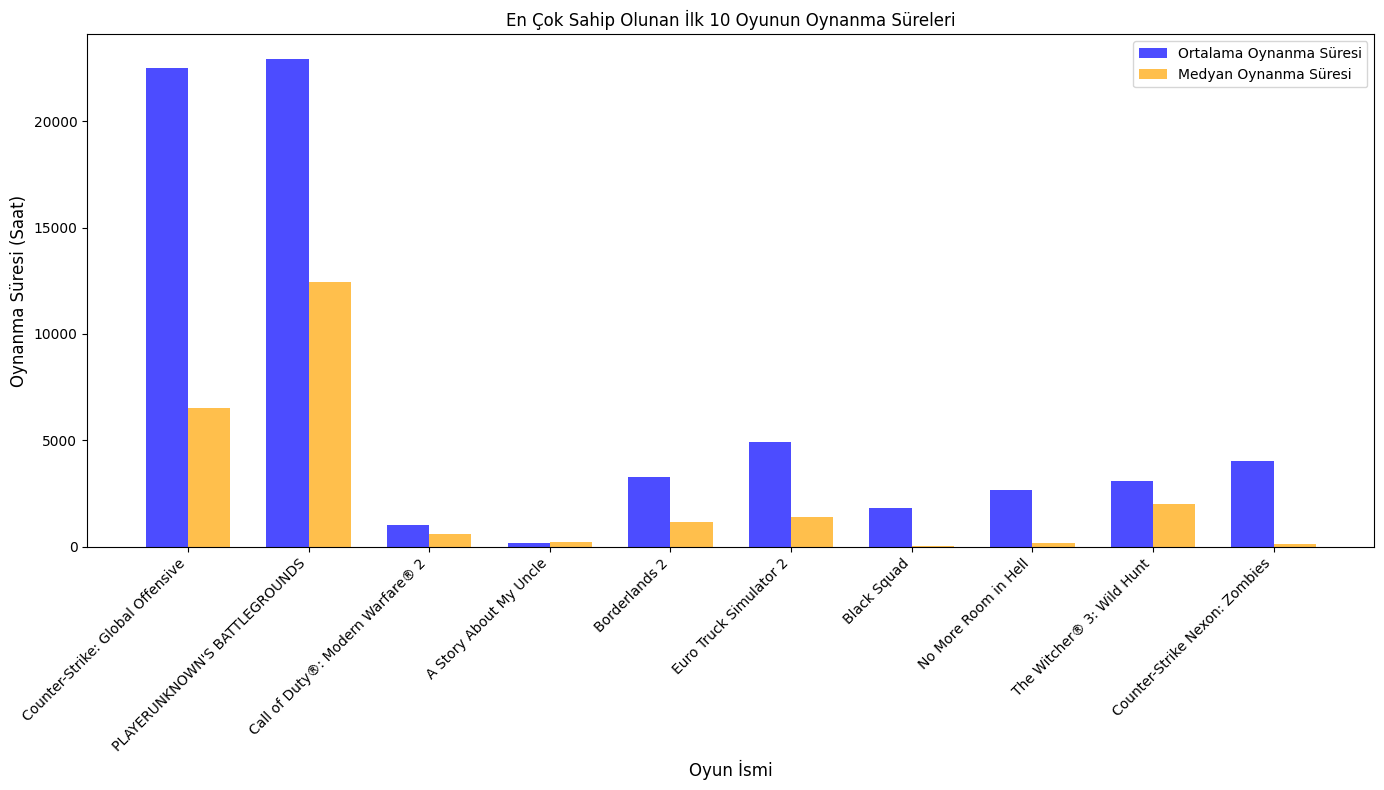

In [13]:
#önce en çok sahip olunan oyunları listelemek istedim, daha sonra bunların oyun oynama süreleri ile ne kadar paralel olduklarına bakacapğım.
#en çok indirilen ilk 10 oyun
top_owned_games = df_steam.sort_values(by="owners", ascending=False).head(10)
top_owned_data = top_owned_games[['name', 'owners', 'average_playtime', 'median_playtime']]
print("En Çok Sahip Olunan 10 Oyun ve Oynanma Süreleri:")
print(top_owned_data)

import matplotlib.pyplot as plt
import numpy as np

#veriler
names = top_owned_data['name']
average_playtime = top_owned_data['average_playtime']
median_playtime = top_owned_data['median_playtime']

#grafik
x = np.arange(len(names))  
width = 0.35  
plt.figure(figsize=(14, 8))

#ortalama oynanma süresi
plt.bar(x - width/2, average_playtime, width, label='Ortalama Oynanma Süresi', color='blue', alpha=0.7)

#medyan oynanma süresi
plt.bar(x + width/2, median_playtime, width, label='Medyan Oynanma Süresi', color='orange', alpha=0.7)

#grafik ayarları
plt.title("En Çok Sahip Olunan İlk 10 Oyunun Oynanma Süreleri", fontsize=12)
plt.xlabel("Oyun İsmi", fontsize=12)
plt.ylabel("Oynanma Süresi (Saat)", fontsize=12)
plt.xticks(x, names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


En Çok Sahip Olunan Oyunların Pozitif ve Negatif Oy Dağılımı
Amaç: En çok sahip olunan ilk 10 oyunun pozitif ve negatif oy sayılarının karşılaştırılması.
Grafikle hangi oyunların daha fazla pozitif veya negatif oy aldığına dair net bir görsel sağlamak istedim.
Oyunların toplam sahiplik sayıları ile pozitif ve negatif oy oranlarının paralellik gösterip göstermediğini görmek istedim.

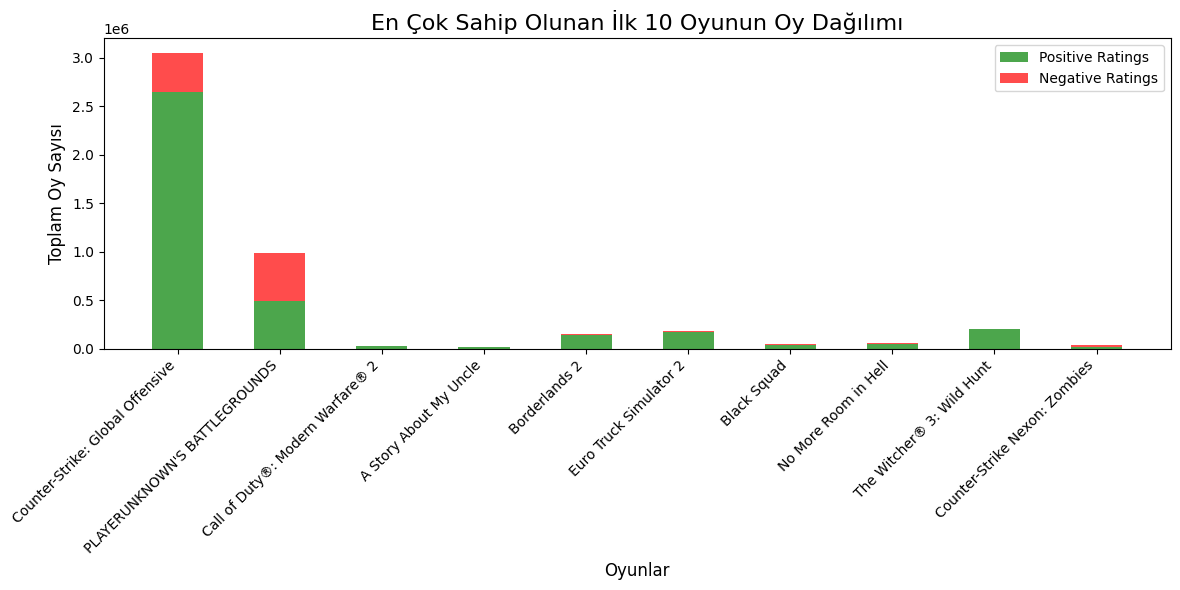

In [14]:
#en çok sahip olunan oyunların pozitif ve negatif oyları
import matplotlib.pyplot as plt

# En çok sahip olunan ilk 10 oyun
top_owned_games = df_steam.sort_values(by="owners", ascending=False).head(10)

# İlk 10 oyunun pozitif ve negatif oylar
top_downloaded_ratings = top_owned_games[["name", "positive_ratings", "negative_ratings"]]

# Toplam oylar için stacked bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.5
index = range(len(top_downloaded_ratings))

# pozitif ve negaitf oyların yığılma çubuk grafiklerini çiz
plt.bar(index, top_downloaded_ratings["positive_ratings"], bar_width, label="Positive Ratings", color="green", alpha=0.7)
plt.bar(index, top_downloaded_ratings["negative_ratings"], bar_width, label="Negative Ratings", color="red", alpha=0.7, bottom=top_downloaded_ratings["positive_ratings"])

# Grafiği düzenle
plt.title("En Çok Sahip Olunan İlk 10 Oyunun Oy Dağılımı", fontsize=16)
plt.xlabel("Oyunlar", fontsize=12)
plt.ylabel("Toplam Oy Sayısı", fontsize=12)
plt.xticks(index, top_downloaded_ratings["name"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


Platform Uyumluluğunun Oyun İndirilme Oranlarına Etkisi
Amaç:Steam'deki en çok indirilen oyunların hangi işletim sistemlerini desteklediğini analiz ederek, çıkarılacak oyunun hangi platformlarda yayınlanması gerektiğine karar vermek.
  - İlk 10 oyunun tamamının Windows desteği bulunuyor. Bu durum, oyunun ilk etapta Windows için çıkarılmasının uygun olacağını gösteriyor.
  - Bazı oyunlar macOS veya Linux desteğine sahip olmamasına rağmen yüksek indirilme sayısına ulaşmış. Bu, oyun tanındıkça diğer platformlara genişleme potansiyeli olduğunu gösteriyor.

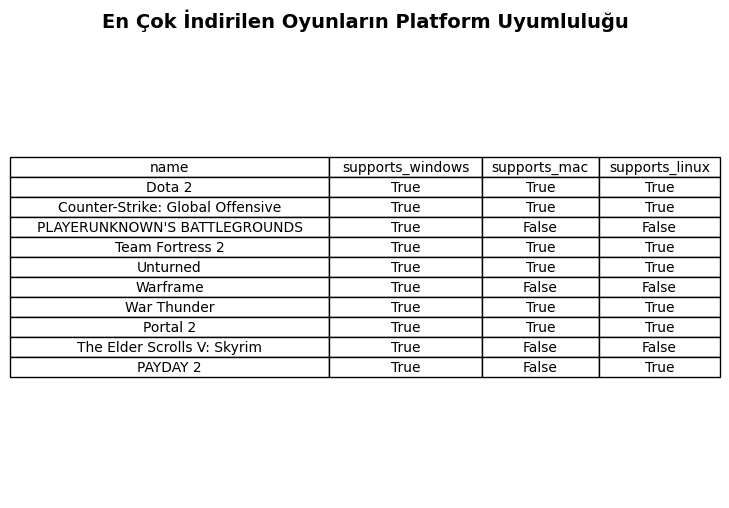

In [15]:
# en çok indirilen oyunların hangi işletim sistemlerine uygun olduğuna bakmak istedim.
import pandas as pd
import matplotlib.pyplot as plt

# Veri seti
df_steam = pd.read_csv('/kaggle/input/steam-store-games/steam.csv')

# İşletim sistemi sütunlarını oluştur
df_steam["supports_windows"] = df_steam["platforms"].str.contains("windows", case=False, na=False)
df_steam["supports_mac"] = df_steam["platforms"].str.contains("mac", case=False, na=False)
df_steam["supports_linux"] = df_steam["platforms"].str.contains("linux", case=False, na=False)

# Owners bilgilerini temizle
df_steam["owners_cleaned"] = df_steam["owners"].str.replace(",", "").str.split("-").str[0].astype(int)

# En çok indirilen ilk 10 oyunu seç
top_downloaded_games = df_steam.sort_values(by="owners_cleaned", ascending=False).head(10)

# Uygunluk tablosu
platform_compatibility = top_downloaded_games[["name", "supports_windows", "supports_mac", "supports_linux"]]

# tablo
plt.figure(figsize=(8, 6))
plt.axis('off')  # Eksenleri kapat
table = plt.table(
    cellText=platform_compatibility.values,
    colLabels=platform_compatibility.columns,
    cellLoc='center',
    loc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Tabloyu ölçeklendirme
table.auto_set_column_width(col=list(range(len(platform_compatibility.columns))))

plt.title("En Çok İndirilen Oyunların Platform Uyumluluğu", fontsize=14, weight='bold')
plt.show()

Takım Oyunları ve Diğer Oyunların Pozitif Oy Ortalamaları
Amaç:Steam'deki oyunları takım oyunları ve diğer oyunlar olarak ikiye ayırarak, bu oyun türlerinin pozitif oy oranlarını karşılaştırmak ve tanımlayıcı türlerin oylara etkisine bakmak.
Takım oyunları genellikle daha yüksek pozitif oy ortalamalarına sahip olabilir. Bu, takım oyunlarının oyuncular arasında daha fazla memnuniyet sağladığını gösterebilir.

Takım oyunlarının ortalama pozitif oyları: 3529.188940092166
Takım oyunu olmayan oyunların ortalama pozitif oyları: 731.4827346655225


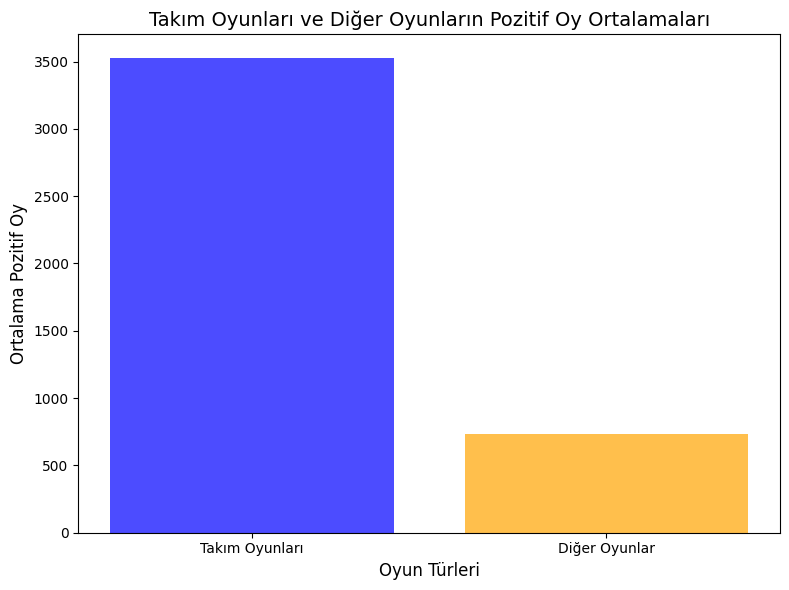

In [16]:
import matplotlib.pyplot as plt

# Takım oyunlarını belirleme
df_steam["is_coop"] = df_steam["categories"].str.contains("Co-op", case=False, na=False)

# Takım oyunları ve diğer oyunların pozitif oylarının ortalaması
coop_ratings = df_steam[df_steam["is_coop"]]["positive_ratings"].mean()
non_coop_ratings = df_steam[~df_steam["is_coop"]]["positive_ratings"].mean()

# Sonuçlar
print("Takım oyunlarının ortalama pozitif oyları:", coop_ratings)
print("Takım oyunu olmayan oyunların ortalama pozitif oyları:", non_coop_ratings)

# grafik
plt.figure(figsize=(8, 6))
categories = ['Takım Oyunları', 'Diğer Oyunlar']
ratings = [coop_ratings, non_coop_ratings]

plt.bar(categories, ratings, color=['blue', 'orange'], alpha=0.7)
plt.title("Takım Oyunları ve Diğer Oyunların Pozitif Oy Ortalamaları", fontsize=14)
plt.ylabel("Ortalama Pozitif Oy", fontsize=12)
plt.xlabel("Oyun Türleri", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Multiplayer ve Single-player Oyunların Sayısı ve Pozitif Oy Ortalamaları
Amaç:Multiplayer ve Single-player oyunların Steam üzerindeki dağılımını ve pozitif oy ortalamalarını analiz etmek.


Multiplayer Oyunların Sayısı: 1081
Single-player Oyunların Sayısı: 25678
Multiplayer Oyunların Ortalama Pozitif Oyları: 3136.627197039778
Single-player Oyunların Ortalama Pozitif Oyları: 761.8995638289587

En Çok İndirilen Multiplayer Oyunlar:
                 name  owners_cleaned
19    Team Fortress 2        20000000
1727      War Thunder        10000000

En Çok İndirilen Single-player Oyunlar:
                             name  owners_cleaned
3362                     Unturned        20000000
1634                     Warframe        20000000
1727                  War Thunder        10000000
23                       Portal 2        10000000
1025  The Elder Scrolls V: Skyrim        10000000
1467                     PAYDAY 2        10000000


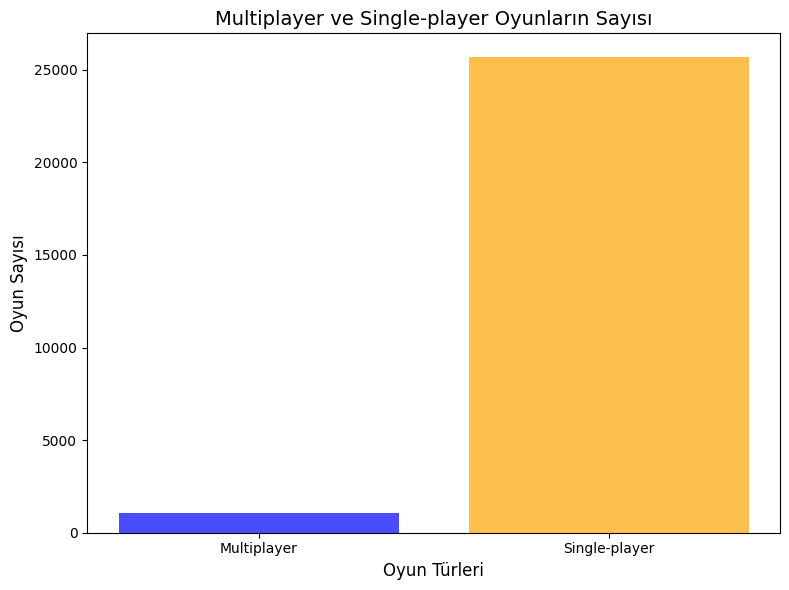

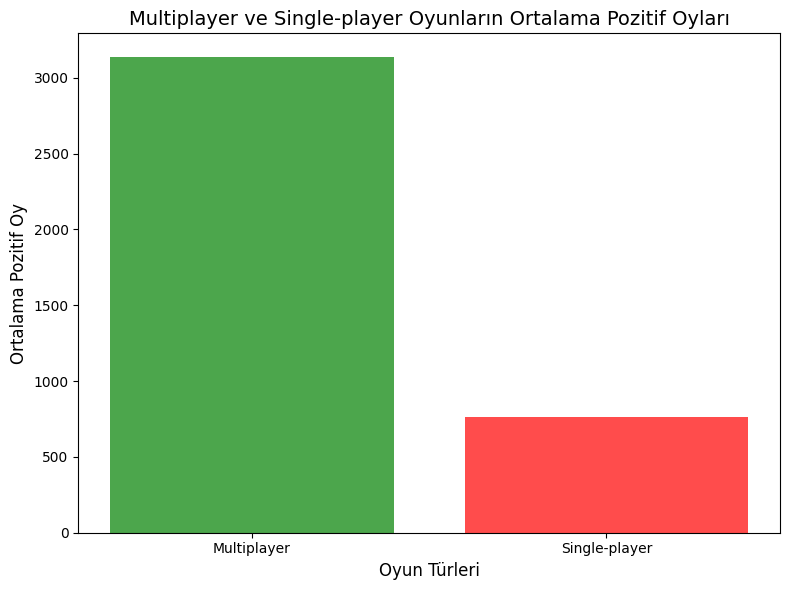

In [17]:
# multiplayer ve singleplayer oyunların sayısına bakmak istedim. daha sonra en çok indirilen oyunların hangi kategoriye girdiğine bakacağım

import matplotlib.pyplot as plt

# Multiplayer ve Single-player sütunlarını oluşturma
df_steam["is_multiplayer"] = df_steam["categories"].str.contains("Multiplayer", case=False, na=False)
df_steam["is_singleplayer"] = df_steam["categories"].str.contains("Single-player", case=False, na=False)

# Multiplayer ve Single-player oyunların sayısını hesaplama
multiplayer_count = df_steam["is_multiplayer"].sum()
singleplayer_count = df_steam["is_singleplayer"].sum()

# Pozitif oylara göre analiz
multiplayer_ratings = df_steam[df_steam["is_multiplayer"]]["positive_ratings"].mean()
singleplayer_ratings = df_steam[df_steam["is_singleplayer"]]["positive_ratings"].mean()

# En çok indirilen oyunlar
top_downloaded_games = df_steam.sort_values(by="owners_cleaned", ascending=False).head(10)
top_downloaded_multiplayer = top_downloaded_games[top_downloaded_games["is_multiplayer"]]
top_downloaded_singleplayer = top_downloaded_games[top_downloaded_games["is_singleplayer"]]

# Sonuçları yazdırma
print("Multiplayer Oyunların Sayısı:", multiplayer_count)
print("Single-player Oyunların Sayısı:", singleplayer_count)
print("Multiplayer Oyunların Ortalama Pozitif Oyları:", multiplayer_ratings)
print("Single-player Oyunların Ortalama Pozitif Oyları:", singleplayer_ratings)

print("\nEn Çok İndirilen Multiplayer Oyunlar:")
print(top_downloaded_multiplayer[["name", "owners_cleaned"]])

print("\nEn Çok İndirilen Single-player Oyunlar:")
print(top_downloaded_singleplayer[["name", "owners_cleaned"]])

# Grafik: Multiplayer ve Single-player oyunların toplam sayısı
plt.figure(figsize=(8, 6))
categories = ['Multiplayer', 'Single-player']
counts = [multiplayer_count, singleplayer_count]
plt.bar(categories, counts, color=['blue', 'orange'], alpha=0.7)
plt.title("Multiplayer ve Single-player Oyunların Sayısı", fontsize=14)
plt.ylabel("Oyun Sayısı", fontsize=12)
plt.xlabel("Oyun Türleri", fontsize=12)
plt.tight_layout()
plt.show()

# Grafik: Multiplayer ve Single-player oyunların pozitif oy ortalamaları
plt.figure(figsize=(8, 6))
ratings = [multiplayer_ratings, singleplayer_ratings]
plt.bar(categories, ratings, color=['green', 'red'], alpha=0.7)
plt.title("Multiplayer ve Single-player Oyunların Ortalama Pozitif Oyları", fontsize=14)
plt.ylabel("Ortalama Pozitif Oy", fontsize=12)
plt.xlabel("Oyun Türleri", fontsize=12)
plt.tight_layout()
plt.show()


En Çok İndirilen Oyunların Hiyerarşik Kümeleme İlişkileri
Amaç:Steam üzerindeki en çok indirilen ilk 10 oyunun kategoriler bazında ilişkilerini analiz ederek, bu oyunların hangi özelliklerde kümelendiğini görselleştirmek.
Grafik, hangi oyunların kategoriler açısından daha benzer olduğunu ve hangi özelliklerde ayrıştığını analiz etmeye yardımcı olmasını umdum.
Kümeleme mesafesi, oyunlar arasındaki kategori benzerliğinin bir ölçütüdür.
Yeni bir oyun tasarlarken, popüler kategoriler arasındaki benzerlikleri kullanarak oyun özelliklerini optimize etmek mümkündür.


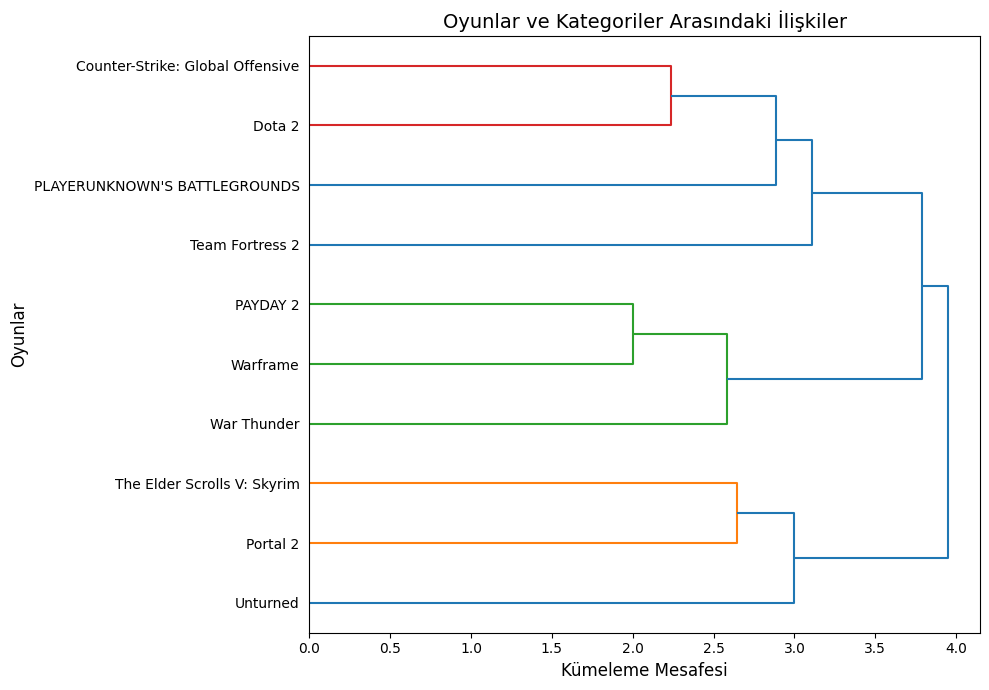

In [18]:
#en çok indiirlen oyunların hiyerarşik tablosu ve ilişkileri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Kategorileri sütunlara ayırma ve NaN değerleri temizle
df_steam["categories"] = df_steam["categories"].fillna("").astype(str)
categories_split = df_steam["categories"].str.get_dummies(sep=";")

# En çok indirilen oyunlar
df_steam["owners_cleaned"] = df_steam["owners"].str.replace(",", "").str.split("-").str[0].astype(int)
top_downloaded_games = df_steam.sort_values(by="owners_cleaned", ascending=False).head(10)

# Kategorileri birleştir
top_downloaded_categories = top_downloaded_games[["name"]].join(categories_split)

# Kategorilere göre oyunlar
categories_matrix = categories_split.loc[top_downloaded_games.index].values

# Hiyerarşik kümeleme
linked = linkage(categories_matrix, method='ward')

# Dendrogram çizimi
plt.figure(figsize=(10, 7))
dendrogram( linked,
    labels=top_downloaded_games["name"].values,
    orientation='right',
    leaf_rotation=0,
    leaf_font_size=10)
plt.title("Oyunlar ve Kategoriler Arasındaki İlişkiler", fontsize=14)
plt.xlabel("Kümeleme Mesafesi", fontsize=12)
plt.ylabel("Oyunlar", fontsize=12)
plt.tight_layout()
plt.show()



En Çok İndirilen Oyunların Yıllara Göre Beklenen Gelir Analizi
Amaç:En çok indirilen ilk 10 oyun için yıllık gelir tahmini yaparak, oyunların gelecekteki finansal potansiyelini değerlendirmek.
Gelir Hesaplama:
Her oyun için gelir, şu şekilde tahmin edilmiştir:
Gelir = Fiyat × Sahiplik Sayısı × (Yıllık %10 artış)
Yayın tarihinden başlayarak 2024 yılına kadar olan tahmini yıllık gelir hesaplanmıştır.
İlk yıllarda yüksek fiyat ve sahiplik oranına sahip oyunlar, daha yüksek gelir potansiyeli gösterir.
Yıllık büyüme oranı (%10) eklenerek, popüler oyunların gelir artışı simüle edilmiştir.


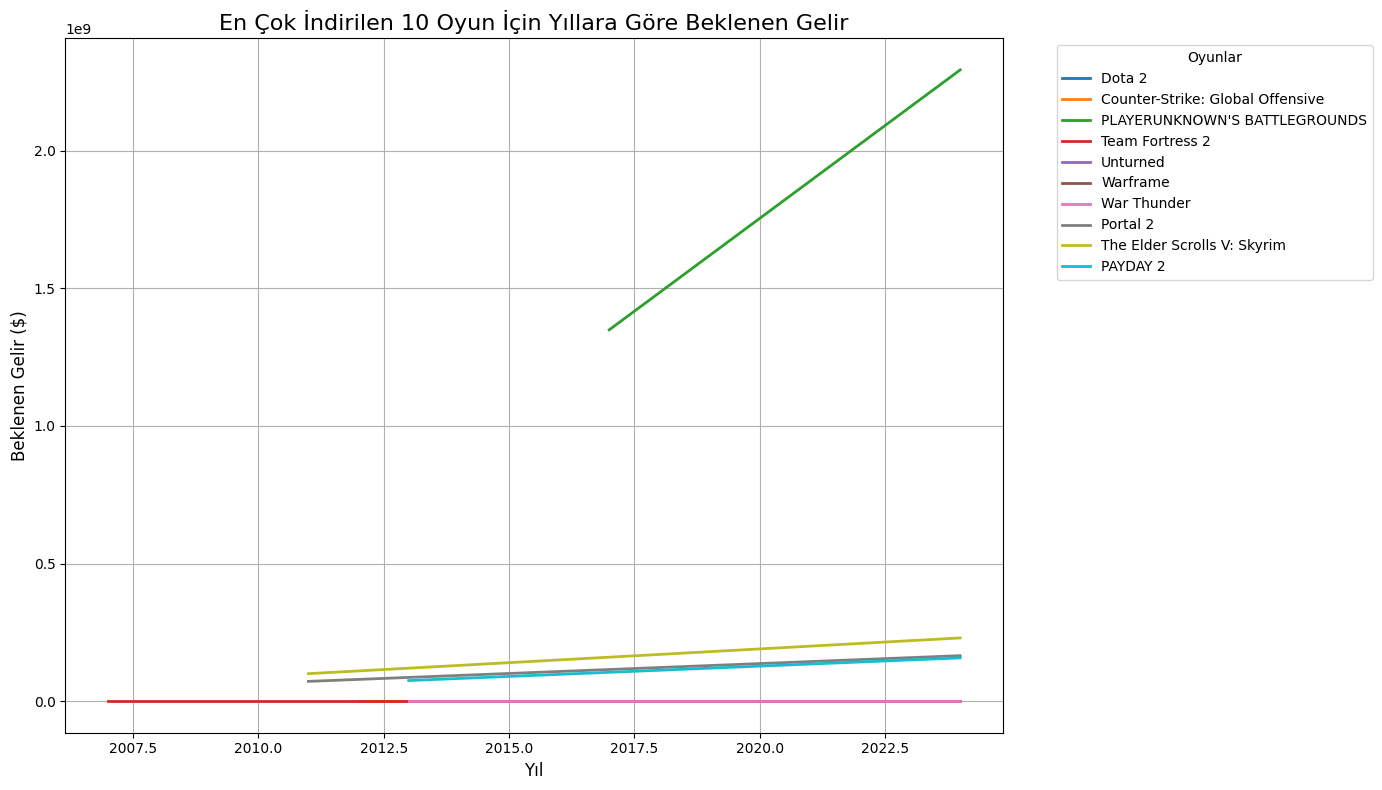

In [19]:
# veri setindeki price ve indirme (sahiplik) sayılarını bildiğim için bir beklenen gelir tablosu yapmaya çalışacağım.

import pandas as pd
import matplotlib.pyplot as plt

# En çok indirilen oyunlar
df_steam["owners_cleaned"] = df_steam["owners"].str.replace(",", "").str.split("-").str[0].astype(int)
top_downloaded_games = df_steam.sort_values(by="owners_cleaned", ascending=False).head(10)

plt.figure(figsize=(14, 8))

# Her oyun için yıllık tahmini gelir hesaplama ve çizim
for game in top_downloaded_games["name"]:
    game_data = top_downloaded_games[top_downloaded_games["name"] == game]
    
 # Yayın tarihinden itibaren yıllık tahminler
    try:
        release_year = pd.to_datetime(game_data["release_date"].values[0]).year
        current_year = 2024
        years_range = list(range(release_year, current_year + 1))
        
 # Gelir tahmini: fiyat x sahiplik x (yıllık %10 artış)
        revenue = [
            game_data["price"].values[0] * 
            (game_data["owners_cleaned"].values[0] * (1 + 0.1 * (year - release_year)))
            for year in years_range]

# Grafiği çiz
        plt.plot(years_range, revenue, label=game, linestyle="-", linewidth=2)
    except Exception as e:
        print(f"Error processing game '{game}': {e}")

# Grafik detayları
plt.title("En Çok İndirilen 10 Oyun İçin Yıllara Göre Beklenen Gelir", fontsize=16)
plt.xlabel("Yıl", fontsize=12)
plt.ylabel("Beklenen Gelir ($)", fontsize=12)
plt.legend(title="Oyunlar", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


Oyun Fiyatlandırma ve Free-to-Play Model Analizi
Amaç:Çıkarılacak oyun için en uygun fiyatlandırma modelini (ücretli veya ücretsiz) belirlemek ve indirilme sayılarının başarı ölçütü olup olmadığını anlamak.
Hipotez:
   - Bir oyunun çok indirilmiş olması, onun başarılı bir oyun olduğu anlamına gelir mi?
   - Bu hipotez, oyunların sahiplik sayıları ile pozitif oy oranları arasındaki ilişkiyi analiz ederek test edilecektir.
  Analiz Soruları:
fiyat ve Sahiplik Arasındaki İlişki:
Ücretli ve ücretsiz oyunların sahiplik sayıları arasındaki farkı analiz ederek, fiyatlandırmanın sahiplik üzerinde ne kadar etkili olduğunu anlamak.
Free-to-Play Oyunların Başarıya Etkisi:
Free-to-Play oyunların pozitif oy oranlarıyla kullanıcı memnuniyeti üzerindeki etkisini değerlendirmek.

In [20]:
#free-to-play oyunları seçme
free_to_play = df_steam[df_steam["price"] == 0].copy() 

#pozitif oy oranı hesaplama
free_to_play.loc[:, "positive_ratio"] = free_to_play["positive_ratings"] / (
    free_to_play["positive_ratings"] + free_to_play["negative_ratings"]
)

#korelasyon hesaplama
import scipy.stats as stats
correlation, p_value = stats.pearsonr(free_to_play["owners_cleaned"], free_to_play["positive_ratio"])

#sonuçları yazdırma
print(f"Korelasyon Katsayısı (r): {correlation}")
print(f"P-değeri: {p_value}")

#korelasyonun gücü
if abs(correlation) > 0.7:
    relation = "Güçlü bir ilişki"
elif 0.4 < abs(correlation) <= 0.7:
    relation = "Orta düzeyde bir ilişki"
else:
    relation = "Zayıf bir ilişki"

print(f"Sahiplik sayısı ile pozitif oy oranı arasında {relation} var.")


Korelasyon Katsayısı (r): 0.04258187940394751
P-değeri: 0.03120752094086177
Sahiplik sayısı ile pozitif oy oranı arasında Zayıf bir ilişki var.


Aksiyon Oyunlarının Fiyat ve Sahiplik Dinamikleri Analizi
Amaç:Aksiyon oyunlarında ücretli ve ücretsiz oyunların sahiplik sayıları üzerindeki etkilerini analiz etmek ve fiyat ile sahiplik sayıları arasındaki ilişkiyi incelemek.
Araştırmak istediklerim:
**Ücretli Oyunların Ortalama Fiyatı:**
   - Ücretli aksiyon oyunlarının fiyat seviyesinin genel kullanıcı kitlesi üzerindeki etkisi.
**Sahiplik Sayıları:**
   - Ücretsiz oyunların daha geniş bir kullanıcı kitlesine hitap ettiği görülür.
**Korelasyon Analizi:**
   - Fiyat ile sahiplik sayısı arasındaki ilişki pozitif, negatif veya zayıf olabilir.
**Görselleştirme:**
   - Çubuk Grafik: Ücretli ve ücretsiz aksiyon oyunlarının sahiplik sayıları kıyaslandı.
   - Scatter Plot: Fiyat ile sahiplik arasındaki ilişkiyi doğrudan gözlemleme imkanı sağlar.
sonuçlarım:
- Yeni çıkarılacak aksiyon oyununun fiyatlandırma stratejisi, hedeflenen kullanıcı kitlesine bağlı olarak belirlenmelidir:
- Geniş kitlelere ulaşmak için Free-to-Play model.
- Gelir odaklı yaklaşım için Premium model.


Ücretli aksiyon oyunlarının ortalama fiyatı: 6.677216334734149
Free-to-play aksiyon oyunlarının ortalama sahiplik sayısı: 572445.1410658307
Ücretli aksiyon oyunlarının ortalama sahiplik sayısı: 81759.54686643522
Fiyat ve Sahiplik Arasındaki Korelasyon: 0.03037171910008587


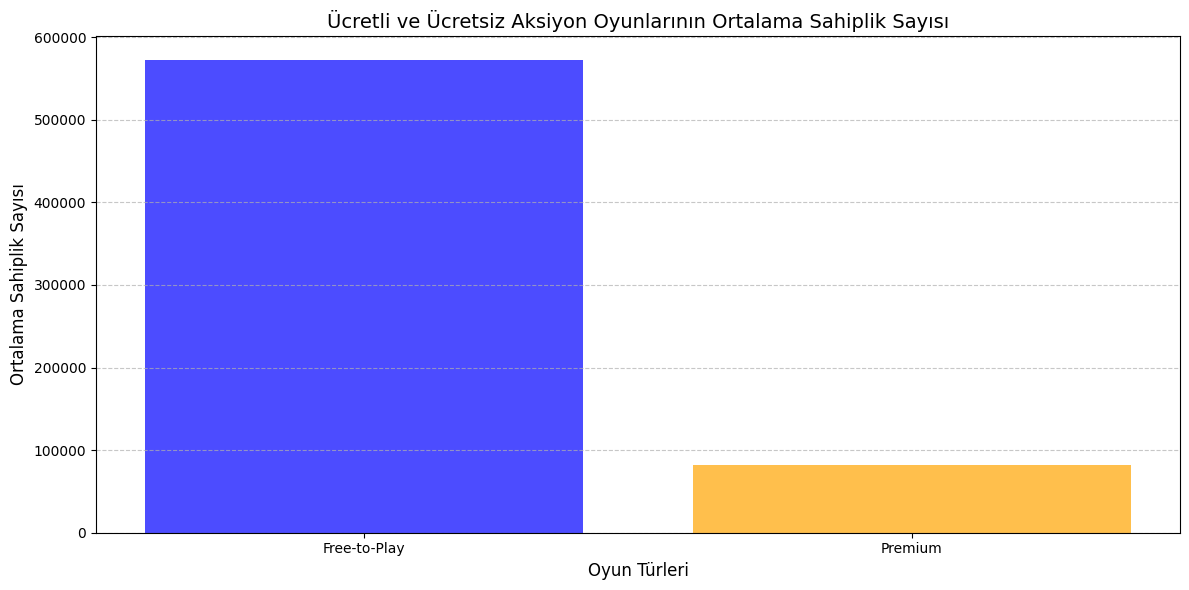

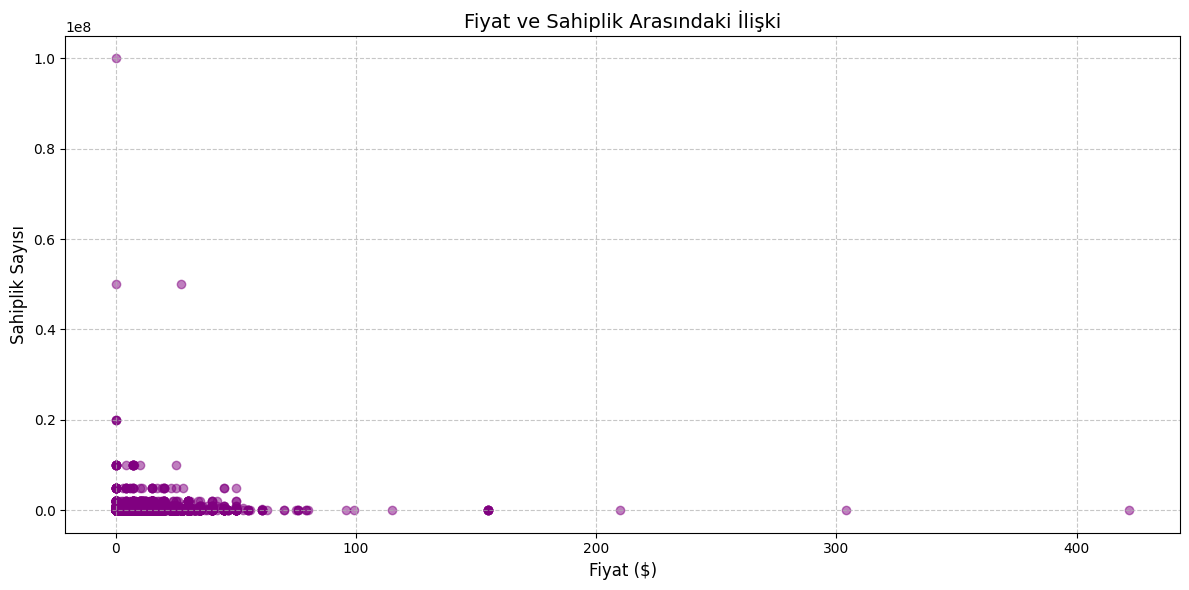

In [21]:
# team veri setindeki aksiyon oyunlarının fiyat ve sahiplik sayıları arasındaki ilişkileri incelemek ve ücretli/ücretsiz aksiyon oyunlarının dinamiklerini anlamak için
import matplotlib.pyplot as plt

# aksiyon oyunlarını seçme
action_games = df_steam[df_steam["genres"].str.contains("Action", case=False, na=False)]

# ücretli ve ücretsiz aksiyon oyunlarını ayırma
premium_action_games = action_games[action_games["price"] > 0]
free_action_games = action_games[action_games["price"] == 0]

# istatistiksel bilgiler
print("Ücretli aksiyon oyunlarının ortalama fiyatı:", premium_action_games["price"].mean())
print("Free-to-play aksiyon oyunlarının ortalama sahiplik sayısı:", free_action_games["owners_cleaned"].mean())
print("Ücretli aksiyon oyunlarının ortalama sahiplik sayısı:", premium_action_games["owners_cleaned"].mean())

# fiyat ve sahiplik arasındaki korelasyon
price_ownership_corr = df_steam[["price", "owners_cleaned"]].corr().iloc[0, 1]
print("Fiyat ve Sahiplik Arasındaki Korelasyon:", price_ownership_corr)

# ücretli ve ücretsiz aksiyon oyunlarının karşılaştırması
plt.figure(figsize=(12, 6))

# ücretli ve ücretsiz oyunların sahiplik sayısı
ownership_counts = [
    free_action_games["owners_cleaned"].mean(),
    premium_action_games["owners_cleaned"].mean()
]

# Çubuk grafiği çiz
categories = ['Free-to-Play', 'Premium']
plt.bar(categories, ownership_counts, color=['blue', 'orange'], alpha=0.7)
plt.title("Ücretli ve Ücretsiz Aksiyon Oyunlarının Ortalama Sahiplik Sayısı", fontsize=14)
plt.ylabel("Ortalama Sahiplik Sayısı", fontsize=12)
plt.xlabel("Oyun Türleri", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Korelasyon grafiği: Fiyat ve sahiplik
plt.figure(figsize=(12, 6))
plt.scatter(df_steam["price"], df_steam["owners_cleaned"], alpha=0.5, color='purple')
plt.title("Fiyat ve Sahiplik Arasındaki İlişki", fontsize=14)
plt.xlabel("Fiyat ($)", fontsize=12)
plt.ylabel("Sahiplik Sayısı", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Tür Bazlı Başarı Tahmini: Pozitif Oy Oranı ve Sahiplik Analizi
Amaç:Geliştirilecek oyunun türünü belirlemek için farklı oyun türlerinin ortalama pozitif oy oranlarını ve sahiplik sayılarını analiz etmek.
Grafik, türlerin oyuncular arasında ne kadar beğenildiğini gösterir.
Yüksek ortalama pozitif oy oranına sahip türler, kullanıcı memnuniyetinin daha yüksek olduğu türleri temsil eder.
Yüksek Beğeni Oranına Sahip Türler:
Bu türler, geliştirilmesi planlanan oyun için güçlü bir referans oluşturabilir.
Sahiplik ve Beğeni Oranı Dengesi:
Yüksek sahiplik oranına sahip ancak düşük beğeni oranı gösteren türler, geliştirme riskleri taşıyabilir.
Stratejik Karar:
Kullanıcıların memnuniyetini en çok artıracak türlerden biri seçilebilir.
Geliştirilecek oyunun türü, yüksek pozitif oy oranına sahip olan ve kullanıcılar tarafından en çok beğenilen türler arasından seçilmelidir.


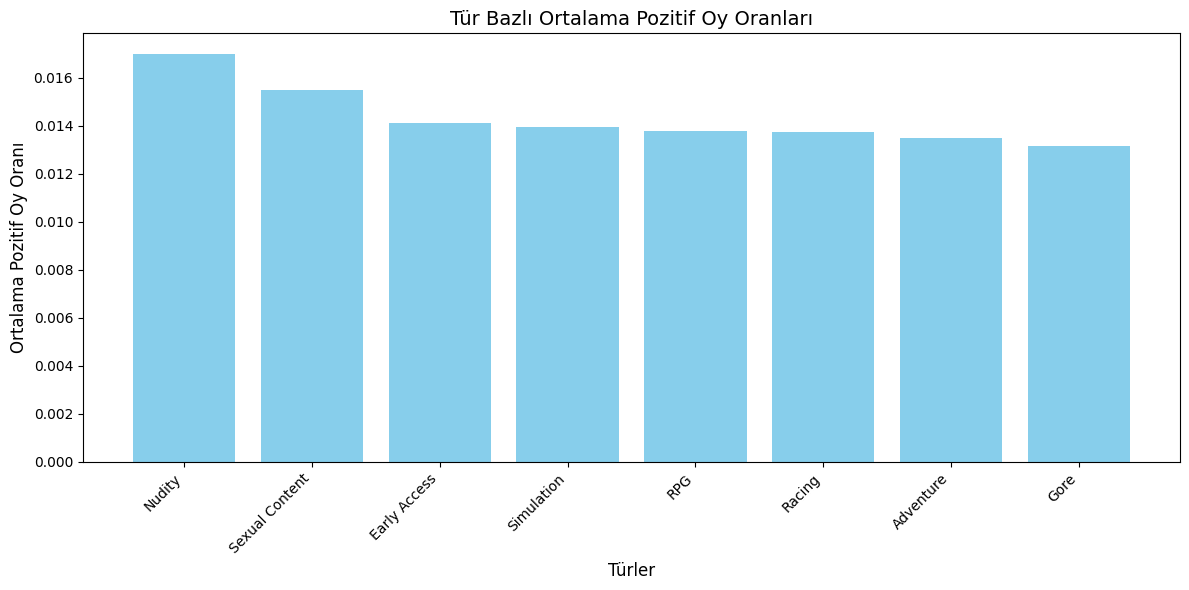

In [22]:
# tür bazlı başarı tahmini için

# türleri sütunlara ayırma
genres_split = df_steam["genres"].str.get_dummies(sep=";")

# tür bazında pozitif oy oranları ve sahiplik sayısı
genres_analysis = genres_split.mul(df_steam["positive_ratings"], axis=0).sum().reset_index()
genres_analysis.columns = ["genre", "total_positive_ratings"]
genres_analysis["total_owners"] = genres_split.mul(df_steam["owners_cleaned"], axis=0).sum().values
genres_analysis["average_positive_rating"] = genres_analysis["total_positive_ratings"] / genres_analysis["total_owners"]

# en popüler türleri seçme
top_genres = genres_analysis.sort_values(by="average_positive_rating", ascending=False).head(10)

# grafik
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(top_genres["genre"], top_genres["average_positive_rating"], color="skyblue")
plt.title("Tür Bazlı Ortalama Pozitif Oy Oranları", fontsize=14)
plt.xlabel("Türler", fontsize=12)
plt.ylabel("Ortalama Pozitif Oy Oranı", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


farklı türlerde tanımlayıcı kategorilere sahip oyunların pozitif oyları ve indirilme sayısına bir etkisi var mı?

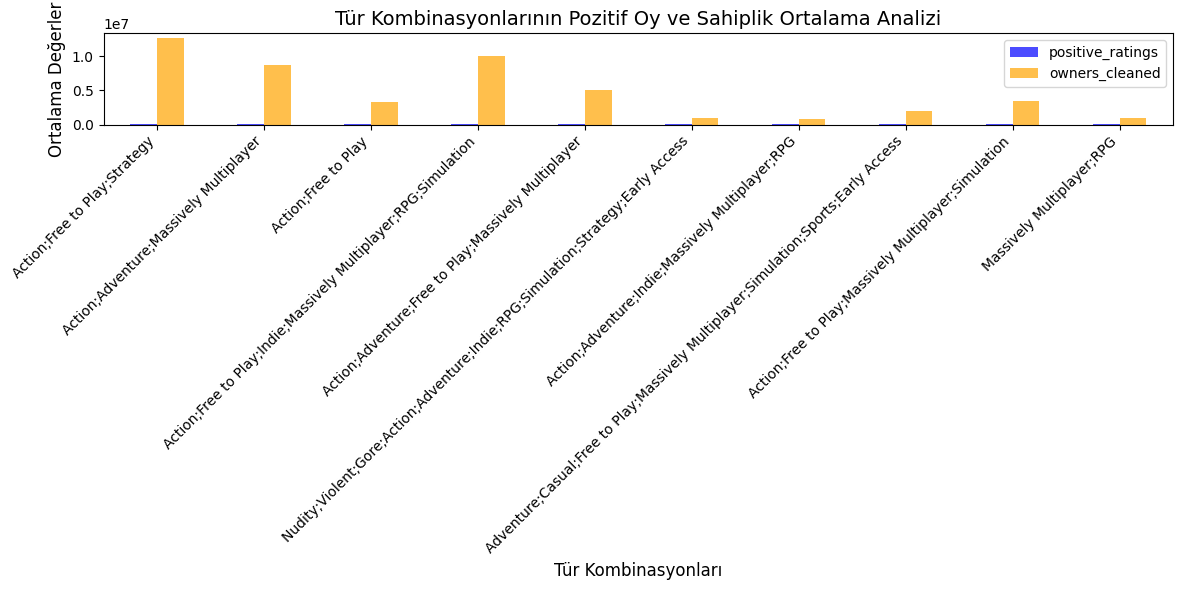

In [23]:
# tür kombinasyınları
df_steam["genre_combinations"] = df_steam["genres"].fillna("Unknown")

# kombinasyonlara göre pozitif oyların totali ve indirilme sayıları
combinations_analysis = (
    df_steam.groupby("genre_combinations")[["positive_ratings", "owners_cleaned"]]
    .mean()
    .sort_values(by="positive_ratings", ascending=False)
    .head(10))

# grafik
combinations_analysis.plot(
    kind="bar", figsize=(12, 6), alpha=0.7, color=["blue", "orange"]
)
plt.title("Tür Kombinasyonlarının Pozitif Oy ve Sahiplik Ortalama Analizi", fontsize=14)
plt.xlabel("Tür Kombinasyonları", fontsize=12)
plt.ylabel("Ortalama Değerler", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Yıllara Göre Oyun Sektörünün Durumu: Toplam Sahiplik Sayıları
Amaç:oyun sektöründeki büyümeyi ve trendleri analiz etmek için yıllık toplam sahiplik sayılarını incelemek.
Grafik, oyun sektöründeki genel büyümeyi veya düşüşleri zaman içinde görselleştirir.
Belirli yıllarda sahiplik sayılarındaki artış veya azalış, sektörün durumuyla ilgili önemli bilgiler sağlar.
Büyüme Yılları:Sahiplik sayılarında belirgin bir artış görülen yıllar, oyun sektöründe önemli dönüm noktaları veya popüler oyunların piyasaya sürüldüğü dönemler olabilir.Düşüş Yılları: Azalan sahiplik sayıları, sektörün daraldığı dönemleri işaret edebilir.
Gelecek oyun için strateji geliştirirken, sektördeki büyüme dönemlerine denk gelen tür ve fiyatlandırma modelleri göz önünde bulundurulabilir.Oyun sektöründeki trendleri anlamak, çıkarılacak oyun için daha bilinçli kararlar alınmasına yardımcı olabilir.


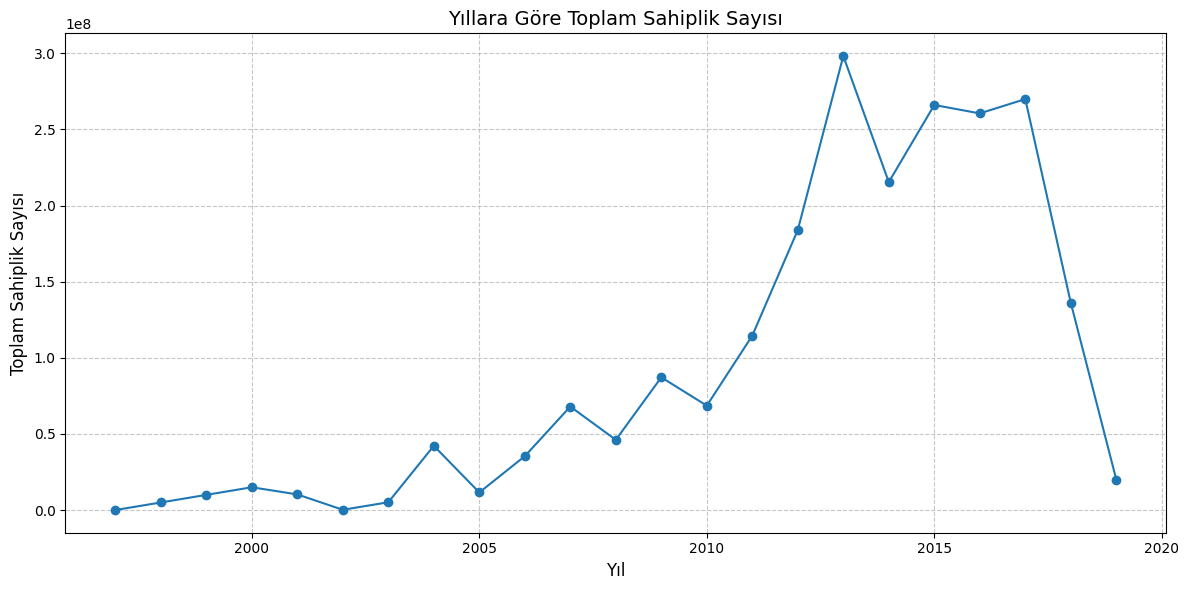

In [24]:
# yılbazında indirme sayılarını hesaplama
df_steam["release_year"] = pd.to_datetime(df_steam["release_date"], errors="coerce").dt.year
yearly_owners = df_steam.groupby("release_year")["owners_cleaned"].sum().reset_index()

# grafik
plt.figure(figsize=(12, 6))
plt.plot(yearly_owners["release_year"], yearly_owners["owners_cleaned"], marker="o", linestyle="-")
plt.title("Yıllara Göre Toplam Sahiplik Sayısı", fontsize=14)
plt.xlabel("Yıl", fontsize=12)
plt.ylabel("Toplam Sahiplik Sayısı", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Türlerin Gelir Paylaşımı Analizi-Amaç:Farklı oyun türlerinin toplam gelirlerini analiz ederek, hangi türlerin finansal olarak daha başarılı olduğunu anlamak.Grafik: oyun türlerinin finansal başarılarını karşılaştırır.Yüksek gelire sahip türler, oyuncular arasında hem popüler hem de ticari olarak kârlı türleri temsil eder.
En Yüksek Gelire Sahip Türler:
Bu türler, finansal başarı açısından geliştirilmesi daha kârlı türlerdir.
Gelir ve Popülerlik İlişkisi:
Yüksek sahiplik sayısına sahip türler genellikle daha yüksek gelir elde eder. Ancak, fiyatlandırma stratejileri de önemli bir faktördür.
Geliştirilecek oyunun türü, yüksek gelire sahip türler arasında seçilebilir.
Free-to-Play model ile gelir modeli bu analize dayalı olarak tasarlanabilir.
Tür bazında gelir analizi, oyun türlerinin ticari performansını anlamak ve gelecekteki oyun geliştirme kararlarını desteklemek için kritik bir adımdır.


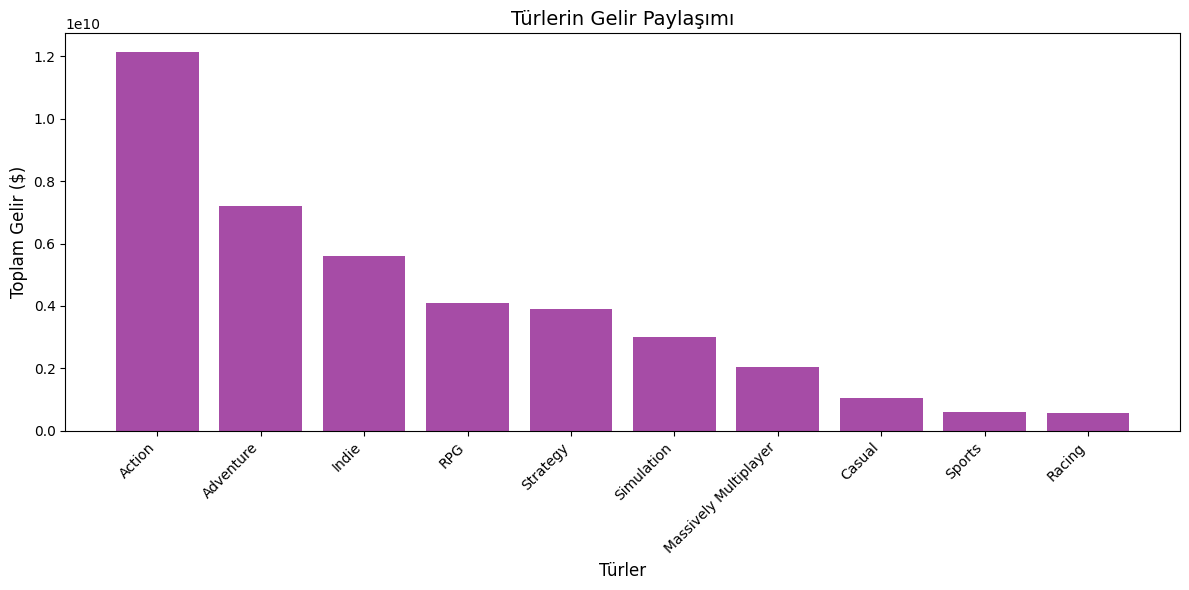

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Türlerin sütunlara ayrılması
genres_split = df_steam["genres"].str.get_dummies(sep=";")

# Her oyun için gelir hesaplama (Fiyat * Sahiplik)
df_steam["revenue"] = df_steam["price"] * df_steam["owners_cleaned"]

# Türlere göre toplam gelir
genres_revenue = genres_split.mul(df_steam["revenue"], axis=0).sum().reset_index()
genres_revenue.columns = ["genre", "total_revenue"]

# Gelire göre türleri sıralama
genres_revenue = genres_revenue.sort_values(by="total_revenue", ascending=False)

# Görselleştirme: İlk 10 tür
plt.figure(figsize=(12, 6))
plt.bar(genres_revenue["genre"].head(10), genres_revenue["total_revenue"].head(10), color="purple", alpha=0.7)
plt.title("Türlerin Gelir Paylaşımı", fontsize=14)
plt.xlabel("Türler", fontsize=12)
plt.ylabel("Toplam Gelir ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


En Çok Kazanan Yayıncılar Analizi
Amaç:Yayıncılar bazında toplam gelirleri analiz ederek, en çok kazanan yayıncıları belirlemek.
grafik, oyun sektöründe hangi yayıncıların finansal olarak en başarılı olduğunu gösterir.
Yayıncıların gelir düzeyine bağlı olarak, sektördeki lider firmalar belirlenebilir.
En Çok Kazanan Yayıncılar:
Bu yayıncılar, sektördeki lider firmalar olarak değerlendirilir.
Yayınlanan oyunların türleri, fiyatlandırma stratejileri ve sahiplik sayıları bu başarıya katkıda bulunur.
Yeni bir oyun çıkarırken, bu yayıncıların stratejileri incelenerek başarılı modeller örnek alınabilir.
Potansiyel iş birliği fırsatları için bu yayıncılar hedeflenebilir.
Yayıncı bazında gelir analizi, sektör liderlerini anlamak ve oyun geliştirme süreçlerinde stratejik kararlar almak için önemli olanilir


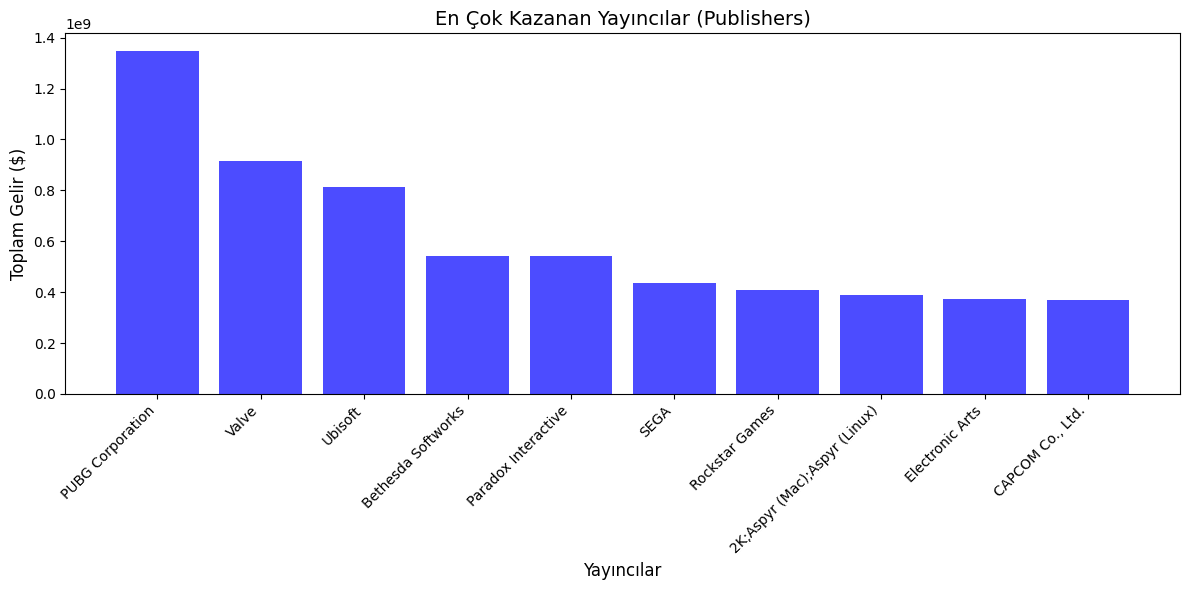

In [26]:
# Publisher bazında toplam gelir hesaplama
publisher_revenue = df_steam.groupby("publisher")["revenue"].sum().reset_index()
publisher_revenue = publisher_revenue.sort_values(by="revenue", ascending=False)

# En çok kazanan ilk 10 publisher
top_publishers = publisher_revenue.head(10)

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.bar(top_publishers["publisher"], top_publishers["revenue"], color="blue", alpha=0.7)
plt.title("En Çok Kazanan Yayıncılar (Publishers)", fontsize=14)
plt.xlabel("Yayıncılar", fontsize=12)
plt.ylabel("Toplam Gelir ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


En Çok Kazanan Geliştiriciler Analizi
Amaç:Geliştiriciler bazında toplam gelirleri analiz ederek, en çok kazanan geliştiricileri belirlemek.
Grafik, oyun sektöründe hangi geliştiricilerin finansal olarak en başarılı olduğunu gösterir.
Geliştiricilerin gelir düzeyine bağlı olarak, sektördeki lider oyun stüdyoları belirlenebilir.
En Çok Kazanan Geliştiriciler:bu geliştiriciler, sektördeki başarılı oyunların yaratıcıları olarak öne çıkar.
Geliştirdikleri oyunların türleri, kullanıcı memnuniyeti ve satış stratejileri bu başarıyı etkiler.
Yeni bir oyun çıkarırken, bu geliştiricilerin projeleri incelenerek başarılı modeller örnek alınabilir.
potansiyel iş birliği fırsatları için bu geliştiriciler hedeflenebilir.
Geliştirici bazında gelir analizi, sektör liderlerini anlamak ve oyun geliştirme süreçlerinde stratejik kararlar almak için önemli olabilir.

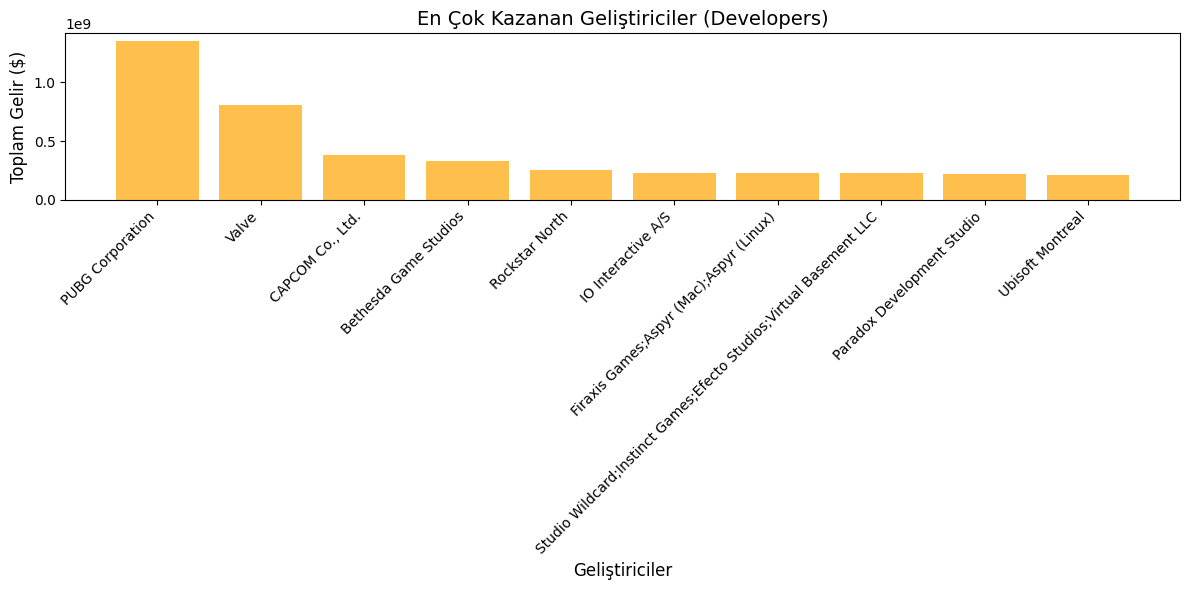

In [27]:
# geliştiric bazında toplam gelir hesaplama
developer_revenue = df_steam.groupby("developer")["revenue"].sum().reset_index()
developer_revenue = developer_revenue.sort_values(by="revenue", ascending=False)

# en çok kazanan ilk 10 developer
top_developers = developer_revenue.head(10)

# Graf
plt.figure(figsize=(12, 6))
plt.bar(top_developers["developer"], top_developers["revenue"], color="orange", alpha=0.7)
plt.title("En Çok Kazanan Geliştiriciler (Developers)", fontsize=14)
plt.xlabel("Geliştiriciler", fontsize=12)
plt.ylabel("Toplam Gelir ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Radar chart ile analiz özeti yapmaya çalıştım. Oyun türlerini Revenue (Gelir), Ownership (Sahiplik), Positive Feedback (Pozitif Oy Oranı) ve Platform Support (Platform Desteği) metrikleri açısından karşılaştırarak, türler arasındaki farklılıkları görselleştirmek istedim. Geliştirilecek oyun için en güçlü yönler birleştirilebilir (örneğin, Action türüyle Indie pozitif geri bildirim oranları birleştirilebilir).
Radar chartla çok uğraştım ama save ederken dosyayı hep hata verdi burda run ettiğimde çalışıyor görünmesine rağmen. vazgeçmek zorunda kaldım.

En çok gelir getiren türler: ['Action', 'Adventure', 'Indie', 'RPG', 'Strategy']
En çok beğenilen türler: ['Indie', 'Action', 'Casual', 'Adventure', 'Strategy']
Platform uyumları:
supports_windows    10
supports_mac         6
supports_linux       7
dtype: int64
Ücretli oyunların ortalama sahiplik sayısı: 81759.54686643522
Free-to-Play oyunların ortalama sahiplik sayısı: 572445.1410658307
Ücretli oyunların ortalama fiyatı: 6.677216334734149
Tahmini ilk yıl geliri: $1,226,393.20


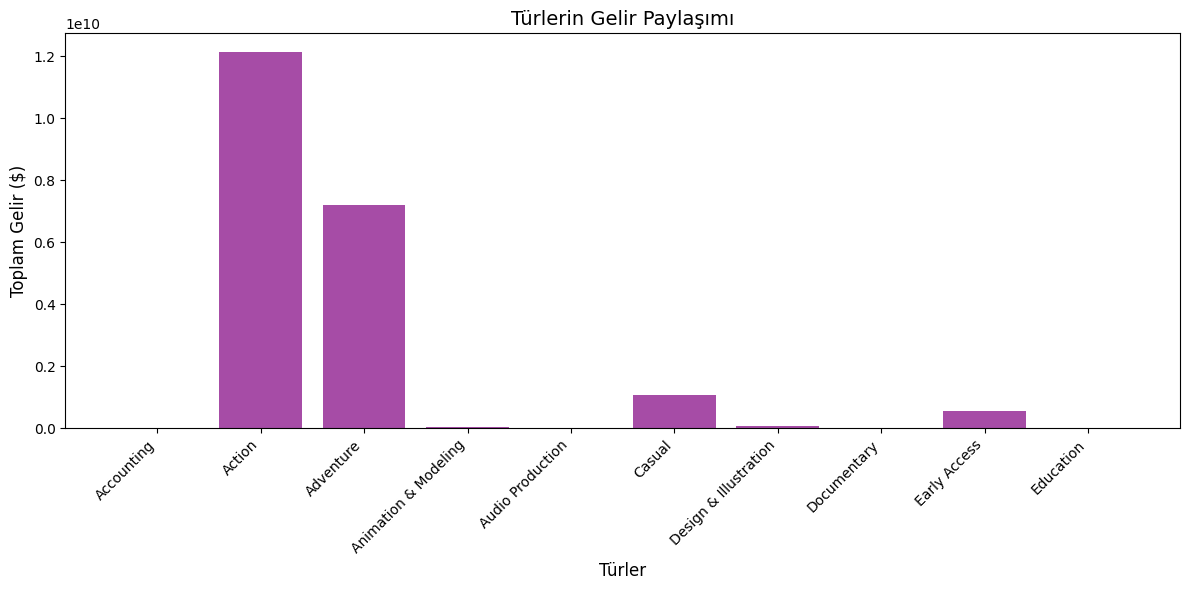

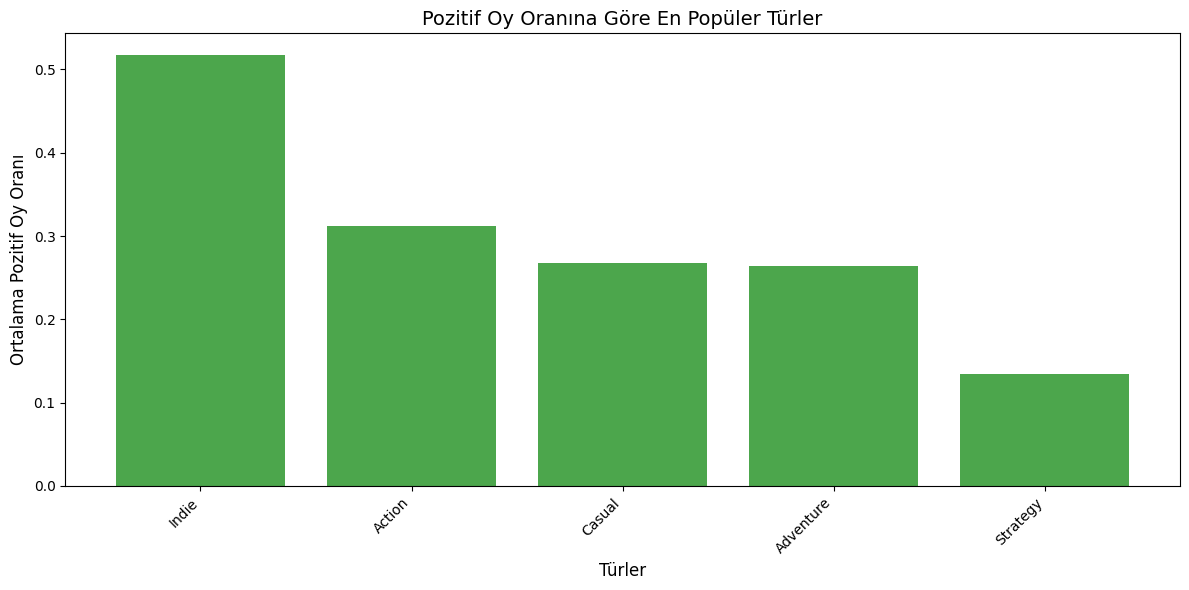

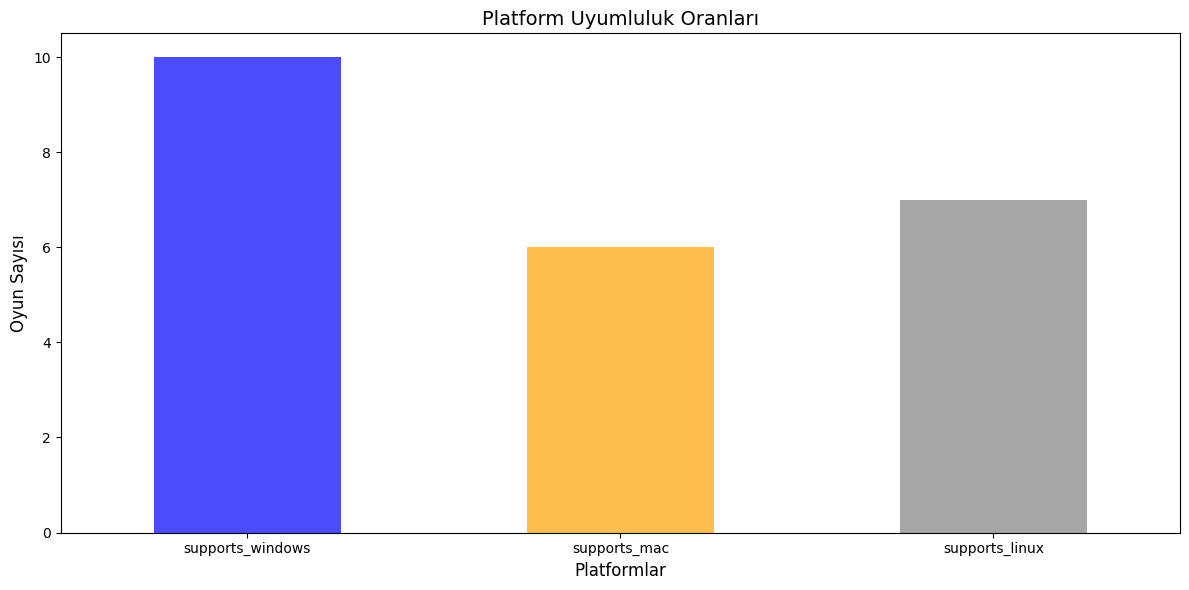

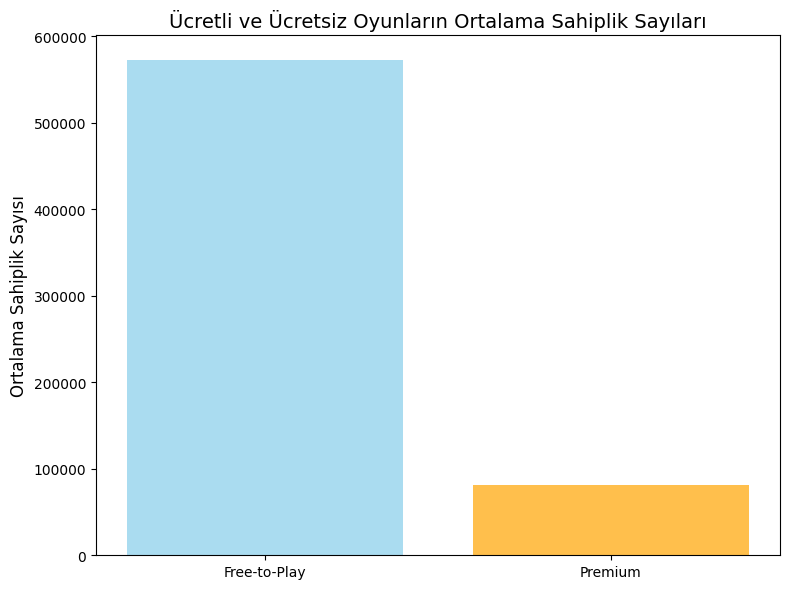

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

#pozitif oy oranını hesaplama
df_steam["positive_ratio"] = df_steam["positive_ratings"] / (
    df_steam["positive_ratings"] + df_steam["negative_ratings"]
)

#türleri ayırma
genres_split = df_steam["genres"].str.get_dummies(sep=";")
genres_revenue = genres_split.mul(df_steam["price"] * df_steam["owners_cleaned"], axis=0).sum().reset_index()
genres_revenue.columns = ["genre", "total_revenue"]

feedback_analysis = genres_split.mul(df_steam["positive_ratio"], axis=0).mean().reset_index()
feedback_analysis.columns = ["genre", "average_positive_ratio"]

#en çok gelir getiren türler
most_profitable_genres = genres_revenue.sort_values(by="total_revenue", ascending=False).head(5)
print("En çok gelir getiren türler:", most_profitable_genres["genre"].tolist())

#pozitif oy oranına göre en popüler türler
top_feedback_genres = feedback_analysis.sort_values(by="average_positive_ratio", ascending=False).head(5)
print("En çok beğenilen türler:", top_feedback_genres["genre"].tolist())

#ilk 10 oyunun platform uyumluluk oranları
df_steam["supports_windows"] = df_steam["platforms"].str.contains("windows", case=False, na=False)
df_steam["supports_mac"] = df_steam["platforms"].str.contains("mac", case=False, na=False)
df_steam["supports_linux"] = df_steam["platforms"].str.contains("linux", case=False, na=False)

top_downloaded_games = df_steam.sort_values(by="owners_cleaned", ascending=False).head(10)
platform_summary = top_downloaded_games[["supports_windows", "supports_mac", "supports_linux"]].sum()
print("Platform uyumları:")
print(platform_summary)

#ücretli ve ücretsiz oyunların karşılaştırması
premium_action_games = df_steam[(df_steam["price"] > 0) & (df_steam["genres"].str.contains("Action", na=False))]
free_action_games = df_steam[(df_steam["price"] == 0) & (df_steam["genres"].str.contains("Action", na=False))]

print("Ücretli oyunların ortalama sahiplik sayısı:", premium_action_games["owners_cleaned"].mean())
print("Free-to-Play oyunların ortalama sahiplik sayısı:", free_action_games["owners_cleaned"].mean())
print("Ücretli oyunların ortalama fiyatı:", premium_action_games["price"].mean())

#gelir tahmini
avg_owners = premium_action_games["owners_cleaned"].mean()  # Ortalama sahiplik sayısı
price = 15  # Örnek fiyat
estimated_revenue_first_year = avg_owners * price
print(f"Tahmini ilk yıl geliri: ${estimated_revenue_first_year:,.2f}")

#grafik: türlerin gelir paylaşımı
plt.figure(figsize=(12, 6))
plt.bar(genres_revenue["genre"].head(10), genres_revenue["total_revenue"].head(10), color="purple", alpha=0.7)
plt.title("Türlerin Gelir Paylaşımı", fontsize=14)
plt.xlabel("Türler", fontsize=12)
plt.ylabel("Toplam Gelir ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#grafik:pozitif oy oranına göre en popüler türler
plt.figure(figsize=(12, 6))
plt.bar(top_feedback_genres["genre"], top_feedback_genres["average_positive_ratio"], color="green", alpha=0.7)
plt.title("Pozitif Oy Oranına Göre En Popüler Türler", fontsize=14)
plt.xlabel("Türler", fontsize=12)
plt.ylabel("Ortalama Pozitif Oy Oranı", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#grafik:platform uyumluluk oranları
platform_summary.plot(kind="bar", figsize=(12, 6), color=["blue", "orange", "gray"], alpha=0.7)
plt.title("Platform Uyumluluk Oranları", fontsize=14)
plt.xlabel("Platformlar", fontsize=12)
plt.ylabel("Oyun Sayısı", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#grafik: ücretli ve ücretsiz oyunların sahiplik sayıları
categories = ['Free-to-Play', 'Premium']
ownership_counts = [
    free_action_games["owners_cleaned"].mean(),
    premium_action_games["owners_cleaned"].mean()
]
plt.figure(figsize=(8, 6))
plt.bar(categories, ownership_counts, color=["skyblue", "orange"], alpha=0.7)
plt.title("Ücretli ve Ücretsiz Oyunların Ortalama Sahiplik Sayıları", fontsize=14)
plt.ylabel("Ortalama Sahiplik Sayısı", fontsize=12)
plt.tight_layout()
plt.show()
